In [1]:
import sys,os
import random
import numpy as np
import json
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import rdkit as rd
from torch_sparse import SparseTensor,transpose
#import deepchem
import tensorflow as tf
import pandas as pd
import pickle

import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test,create_dataset_for_test_bootstrap
import seaborn as sns


from statannotations.Annotator import Annotator

/rds/user/co-gora1/hpc-work/DGraphDTA/emetrics.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pair is not 0:
RDKit WARNING: [10:14:18] Enabling RDKit 2019.09.3 jupyter extensions
[10:14:18] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
!pip install seaborn statannotations

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thur vs. Fri: t-test independent samples, P_val:8.004e-01 t=2.537e-01
Thur vs. Sat: t-test independent samples, P_val:6.282e-02 t=-1.875e+00
Sun vs. Fri: t-test independent samples, P_val:6.036e-02 t=1.901e+00


(<AxesSubplot:xlabel='day', ylabel='total_bill'>,
  <statannotations.Annotation.Annotation at 0x14b9cf389dc0>])

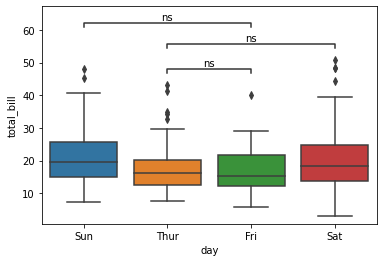

In [22]:


df = sns.load_dataset("tips")
x = "day"
y = "total_bill"
order = ['Sun', 'Thur', 'Fri', 'Sat']

ax = sns.boxplot(data=df, x=x, y=y, order=order)

pairs=[("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")]

annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

### Loading the Trained Model and Testing

In [2]:
datasets = ['davis', 'kiba'][1]
datasets 

'kiba'

In [3]:
dataset = ['davis', 'kiba'][1]
dataset 

'kiba'

In [4]:


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_pconcs4_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + '_pconcs4_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')

def calculate_metrics1(Y, P, dataset):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse,mse,rm2



In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

cuda_name: cuda:0


In [6]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][0]
method

'pconsc4'

In [7]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconsc4__188_2000_GNNNet_kiba_1.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [8]:
rmse1=[]
pearson1=[]
ci1=[]
mse1=[]
rm21=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y, P = predicting(model, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y, P, datasets)
    print(cindex,pearson,rmse)
    ci1.append(cindex)
    pearson1.append(pearson)
    rmse1.append(rmse)
    mse1.append(mse)
    rm21.append(rm2)




0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614261438731198
cindex2 0.8586280846564456
rm2: 0.6747953773906761
mse: 0.20831765
pearson 0.8233175316469125
0.8614261438731198 0.8233175316469125 0.45641828660199807
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8516725333102987
cindex2 0.8476616010959045
rm2: 0.5778243070823978
mse: 0.22758716
pearson 0.7780735448583178
0.8516725333102987 0.7780735448583178 0.4770609640793656
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.855916780680609
cindex2 0.8586472268986759
rm2: 0.6281271688303774
mse: 0.23503818
pearson 0.8055032893724791
0.855916780680609 0.8055032893724791 0.48480735986464996
3
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective p

In [9]:
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_1, P_1 = predicting(model, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


In [8]:
name=method+"_2000_188"
result_file_name = 'results2/' + name + '.txt'

result_str = ''
result_str += datasets + '\r\n'
result_str += 'rmse:' + str(np.mean(rmse1)) + ' ' + ' mse:' + str(np.mean(mse1)) + ' ' + ' pearson:' + str(
         np.mean(pearson1)) + ' '  + 'ci:' + str(np.mean(ci1)) + ' ' + 'rm2:' + str(np.mean(rm21))
print(result_str)
open(result_file_name, 'w').writelines(result_str)

kiba
rmse:0.46627464485146397  mse:0.21796775  pearson:0.8269275117108792 ci:0.860688653895836 rm2:0.6669443882199839


In [9]:
name=method+"_2000_188_Y"
result_file_name = 'results2/' + name + '.txt'
with open(result_file_name, 'w') as f:
    for item in Y:
        f.write("%s\n" % item)

In [10]:
name=method+"_2000_188_P"
result_file_name = 'results2/' + name + '.txt'
with open(result_file_name, 'w') as f:
    for item in P:
        f.write("%s\n" % item)

In [10]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][0]
method

'pconsc4'

In [11]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconcs4_2_188_2000_GNNNet_kiba_3.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model1 = GNNNet()
model1.to(device)
model1.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [12]:
rmse2=[]
pearson2=[]
ci2=[]
mse2=[]
rm22=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y2, P2 = predicting(model1, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y2, P2, datasets)
    print(cindex,pearson,rmse)
    ci2.append(cindex)
    pearson2.append(pearson)
    rmse2.append(rmse)
    mse2.append(mse)
    rm22.append(rm2)




0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8500430066922608
cindex2 0.851664691235909
rm2: 0.6480084185342478
mse: 0.20500678
pearson 0.8285120158927118
0.8500430066922608 0.8285120158927118 0.4527767421590953
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8441272377826247
cindex2 0.8458649664784681
rm2: 0.59601296385084
mse: 0.21731515
pearson 0.7902198219105354
0.8441272377826247 0.7902198219105354 0.4661707329803998
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8439116554824418
cindex2 0.8445493255197289
rm2: 0.59075715810632
mse: 0.2564413
pearson 0.7864042376786035
0.8439116554824418 0.7864042376786035 0.506400330

In [13]:
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_2, P_2 = predicting(model1, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


In [14]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][0]
method

'pconsc4'

In [15]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconcs4_3_188_2000_GNNNet_kiba_2.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model2 = GNNNet()
model2.to(device)
model2.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

GNNNet Loaded


<All keys matched successfully>

In [16]:
rmse3=[]
pearson3=[]
ci3=[]
mse3=[]
rm23=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y3, P3 = predicting(model2, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y3, P3, datasets)
    print(cindex,pearson,rmse)
    ci3.append(cindex)
    pearson3.append(pearson)
    rmse3.append(rmse)
    mse3.append(mse)
    rm23.append(rm2)




0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8423920112446767
cindex2 0.8445403499496905
rm2: 0.649900033121121
mse: 0.22290051
pearson 0.8084540455596302
0.8423920112446767 0.8084540455596302 0.47212340530235264
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8220333858811842
cindex2 0.8303897971637925
rm2: 0.6045088180038077
mse: 0.22400321
pearson 0.7801391781780114
0.8220333858811842 0.7801391781780114 0.47328977451852416
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.830664321236997
cindex2 0.8310308046213357
rm2: 0.573283833784695
mse: 0.28282252
pearson 0.7591454252555287
0.830664321236997 0.7591454252555287 0.53181

In [17]:
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y_3, P_3 = predicting(model2, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 15908 samples...


In [34]:
len(Y_1)

15908

In [ ]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps','rand_cmaps'][3]
method

In [ ]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_random_188_2000_GNNNet_kiba_1.model'
#result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))

In [ ]:
rmse4=[]
pearson4=[]
ci4=[]
mse4=[]
rm24=[]
niters=20

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y4, P4 = predicting(model, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y4, P4, datasets)
    print(cindex,pearson,rmse)
    ci4.append(cindex)
    pearson4.append(pearson)
    rmse4.append(rmse)
    mse4.append(mse)
    rm24.append(rm2)

In [6]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

22582272

In [21]:
torch.cuda.empty_cache()

In [21]:
print(t,r,a,f)

6222839808 29360128 6777856 22582272


In [22]:
er1=np.abs(Y-P)
er2=np.abs(Y2-P2)
er3=np.abs(Y3-P3)

In [23]:
a = np.array([er1,er2,er3])


In [24]:
totalers=np.mean(a, axis=0)

In [79]:

with open('test_errors_file.txt', 'w') as f:
    for item in totalers:
        f.write("%s\n" % item)

In [26]:
totalers

array([0.02078088, 1.9536902 , 0.6546564 , 0.49695563, 0.04148984,
       0.04077721, 0.12596242, 0.03697928, 0.16207893, 1.4814311 ,
       0.19532792, 0.25842834, 0.1843648 , 0.05922723, 0.03049858,
       0.18499152, 0.08256046, 0.21291463, 0.07315525, 0.13042863,
       0.2367986 , 0.7934348 , 0.24658172, 0.03166429, 0.3477362 ,
       0.12269672, 0.64655775, 1.7758857 , 0.05134106, 0.07835682,
       0.1691807 , 0.19969352, 0.7011232 , 0.08302744, 0.04187926,
       0.11477057, 0.03495781, 0.3448268 , 0.03157083, 0.22784646,
       0.06913408, 0.5260878 , 0.07544001, 0.05650624, 0.02050869,
       0.86035985, 0.0589176 , 0.16689603, 1.4232072 , 0.01193889,
       0.38617754, 0.16732343, 0.34530577, 0.4588058 , 0.16359217,
       0.3675548 , 0.15713103, 0.07846403, 0.1688072 , 0.3082334 ,
       0.07352916, 0.33844915, 0.12741287, 0.02153746, 0.11684958,
       0.14286645, 0.07818246, 0.18701775, 0.2487073 , 0.11341143,
       0.03216553, 0.40765008, 0.08326586, 0.258238  , 0.21316

In [11]:
print(Y,P)

[ 3.199999    1.3617278   3.7999997   4.          3.6         3.7999997
  3.4000006   3.6         3.5000002  -0.40011692  3.6         3.4000006
  2.7000024   3.8999999   3.5000002   3.4000006   3.8999999   3.1000016
  4.39794     3.8999999   3.8999999   2.4000022   3.7999997   3.7999997
  3.6999998   3.4000006   3.6         3.5000002   3.6999998   3.6999998
  3.6         3.5000002   3.1000016   3.7999997   3.6         4.
  3.8999999   3.5000002   3.8999999   3.          3.8999999   2.8500044
  3.7999997   3.2999995   3.8999999   4.69897     3.8999999   3.5000002
  3.1000016   3.6999998   2.          3.199999    2.500003    3.7999997
  3.199999    3.          4.69897     3.8999999   1.6627579   5.30103
  3.6         3.199999    3.8999999   3.199999    3.8999999   3.1000016
  3.7999997   3.7999997   4.603144    3.8999999   3.5000002   3.1000016
  3.8999999   3.6         4.2         3.6999998   3.7999997   3.199999
  4.39794     3.8999999   4.          3.8999999   3.8999999   3.7999997
  

In [12]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})

In [21]:
data_ci1

[[0.8614261438731198,
  0.8516725333102987,
  0.855916780680609,
  0.8462717811127163,
  0.8588235777232073,
  0.8667718764561592,
  0.8726706903845429,
  0.8737399476543807,
  0.851870852571562,
  0.8649750773824083,
  0.8600781124514967,
  0.855433628318584,
  0.8588242733004534,
  0.8470764617691154,
  0.8660347471051139,
  0.877264725221117,
  0.8558398333290989,
  0.8716351265149904,
  0.8471980478841542,
  0.870244689983898],
 [0.8440178740008811,
  0.8351178007644633,
  0.8332529806502053,
  0.8540681242865988,
  0.8464754145484112,
  0.8632463227859787,
  0.8761136079011187,
  0.8529183114650727,
  0.8588112130198493,
  0.8610658952322315,
  0.8558132064146892,
  0.8391920874544508,
  0.8598404783841888,
  0.8351123583507392,
  0.8551413348241891,
  0.8730608522281376,
  0.853887717336992,
  0.8637763129917074,
  0.8531993712096628,
  0.8711565648584352],
 [0.84305704155915,
  0.8343835705184961,
  0.8459747649141095,
  0.8348405140279421,
  0.8444591364909371,
  0.863501288013

In [16]:
data_ci  = pd.read_pickle('results2/ci.pkl')

In [17]:
data_ci 

,Pconsc4,ESM,AlphaFold,Random
0,0.861426,0.844018,0.843057,0.851480
1,0.851673,0.835118,0.834384,0.834345
2,0.855917,0.833253,0.845975,0.845575
3,0.846272,0.854068,0.834841,0.845194
4,0.858824,0.846475,0.844459,0.854541
5,0.866772,0.863246,0.863501,0.857422
6,0.872671,0.876114,0.848545,0.870855
7,0.873740,0.852918,0.850767,0.862360
8,0.851871,0.858811,0.839141,0.865802
9,0.864975,0.861066,0.851438,0.846939


In [13]:
data_1 = ci1
data_2 = ci2
data_3 = ci3
data_4= ci4

data_ci1 = [data_1, data_2, data_3,data_4]
data_ci = pd.DataFrame(
{'Pconsc4':data_1,
 'ESM': data_2,
 'AlphaFold': data_3,
 'Random':data_4
})

NameError: name 'ci2' is not defined

In [18]:
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']

ax = sns.boxplot(data=df, x=x, y=y, order=order)


annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

NameError: name 'df' is not defined

In [45]:
sns.set_theme(style="whitegrid")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pconsc4 vs. ESM: t-test paired samples, P_val:6.304e-03 t=3.070e+00
ESM vs. AlphaFold: t-test paired samples, P_val:4.738e-03 t=3.198e+00
AlphaFold vs. Random: t-test paired samples, P_val:3.308e-03 t=-3.357e+00
Pconsc4 vs. AlphaFold: t-test paired samples, P_val:6.436e-08 t=8.525e+00
ESM vs. Random: t-test paired samples, P_val:8.948e-01 t=1.341e-01
Pconsc4 vs. Random: t-test paired samples, P_val:1.247e-03 t=3.787e+00


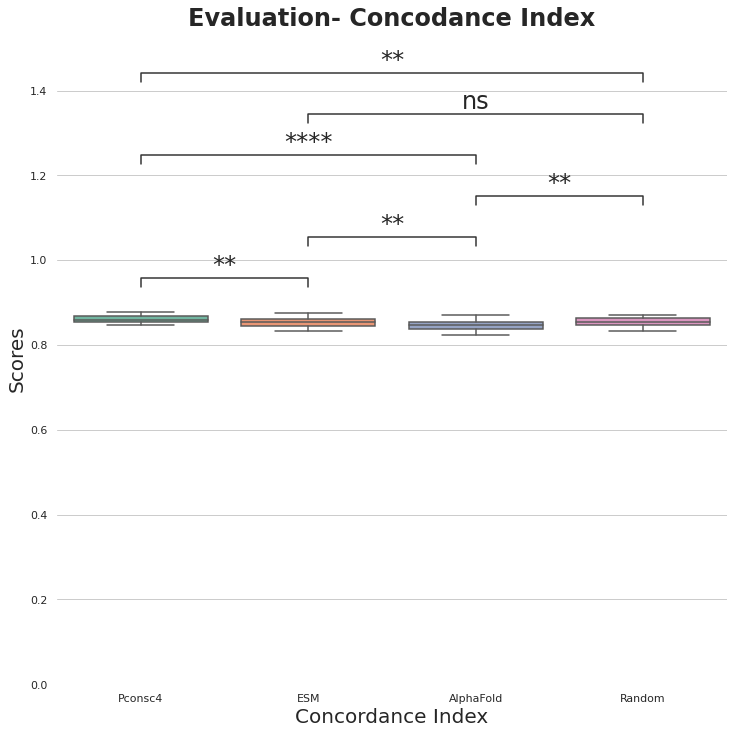

In [46]:
f, ax = plt.subplots(figsize=(12, 12))
# sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']
pairs=[("Pconsc4", "ESM"), ("ESM", "AlphaFold"), ("AlphaFold", "Random"),("Pconsc4", "Random"),("Pconsc4", "AlphaFold"),("ESM", "Random")]
sns.set(font_scale = 2)
ax=sns.boxplot(data=data_ci, palette="Set2",order=order)

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Concordance Index',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Evaluation- Concodance Index',fontsize=24,fontweight='bold')
sns.despine(left=True, bottom=True)
annotator = Annotator(ax, pairs, data=data_ci, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
plt.savefig(os.path.join('results2',  'boxplot_CI_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results2',  'boxplot_CI_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [37]:
data_rmse  = pd.read_pickle('results2/rmse.pkl')

In [ ]:
data_1 = rmse1
data_2 = rmse2
data_3 = rmse3
data_4= rmse4

data_rmse1 = [data_1, data_2, data_3,data_4]
data_rmse = pd.DataFrame(
{'Pconsc4':data_1,
 'ESM': data_2,
 'AlphaFold': data_3,
 'Random':data_4
})

In [48]:
sns.set_theme(style="whitegrid")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pconsc4 vs. ESM: t-test paired samples, P_val:8.118e-01 t=-2.414e-01
ESM vs. AlphaFold: t-test paired samples, P_val:7.449e-04 t=-4.012e+00
AlphaFold vs. Random: t-test paired samples, P_val:8.159e-03 t=2.954e+00
Pconsc4 vs. AlphaFold: t-test paired samples, P_val:3.550e-04 t=-4.337e+00
ESM vs. Random: t-test paired samples, P_val:5.026e-02 t=-2.090e+00
Pconsc4 vs. Random: t-test paired samples, P_val:2.339e-03 t=-3.511e+00


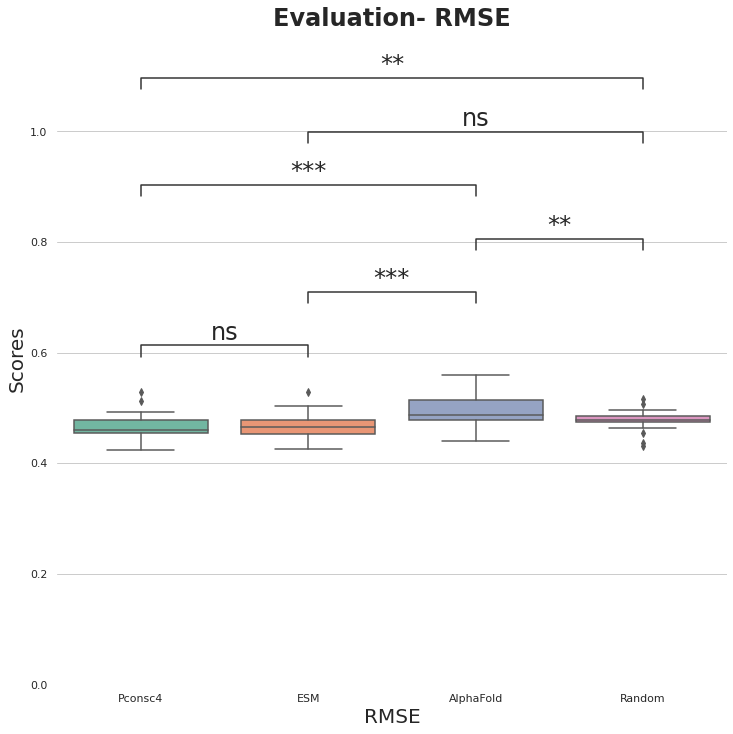

In [49]:
f, ax = plt.subplots(figsize=(12, 12))

# Draw a violinplot with a narrower bandwidth than the default
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']
pairs=[("Pconsc4", "ESM"), ("ESM", "AlphaFold"), ("AlphaFold", "Random"),("Pconsc4", "Random"),("Pconsc4", "AlphaFold"),("ESM", "Random")]
sns.set(font_scale = 2)

ax=sns.boxplot(data=data_rmse, palette="Set2",order=order)

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('RMSE',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Evaluation- RMSE',fontsize=24,fontweight='bold')
sns.despine(left=True, bottom=True)
annotator = Annotator(ax, pairs, data=data_rmse, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
plt.savefig(os.path.join('results2',  'boxplot_rmse_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results2',  'boxplot_rmse_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [42]:

data_pearson  = pd.read_pickle('results2/pearson.pkl')

In [ ]:
data_1 = pearson1
data_2 = pearson2
data_3 = pearson3
data_4= pearson4

data_pearson1 = [data_1, data_2, data_3,data_4]
data_pearson = pd.DataFrame(
{'Pconsc4':data_1,
 'ESM': data_2,
 'AlphaFold': data_3,
 'Random':data_4
})

In [43]:
sns.set_theme(style="whitegrid")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pconsc4 vs. ESM: t-test paired samples, P_val:7.882e-01 t=-2.724e-01
ESM vs. AlphaFold: t-test paired samples, P_val:3.516e-04 t=4.341e+00
AlphaFold vs. Random: t-test paired samples, P_val:5.362e-03 t=-3.142e+00
Pconsc4 vs. AlphaFold: t-test paired samples, P_val:2.464e-04 t=4.498e+00
ESM vs. Random: t-test paired samples, P_val:3.230e-02 t=2.310e+00
Pconsc4 vs. Random: t-test paired samples, P_val:4.077e-03 t=3.265e+00


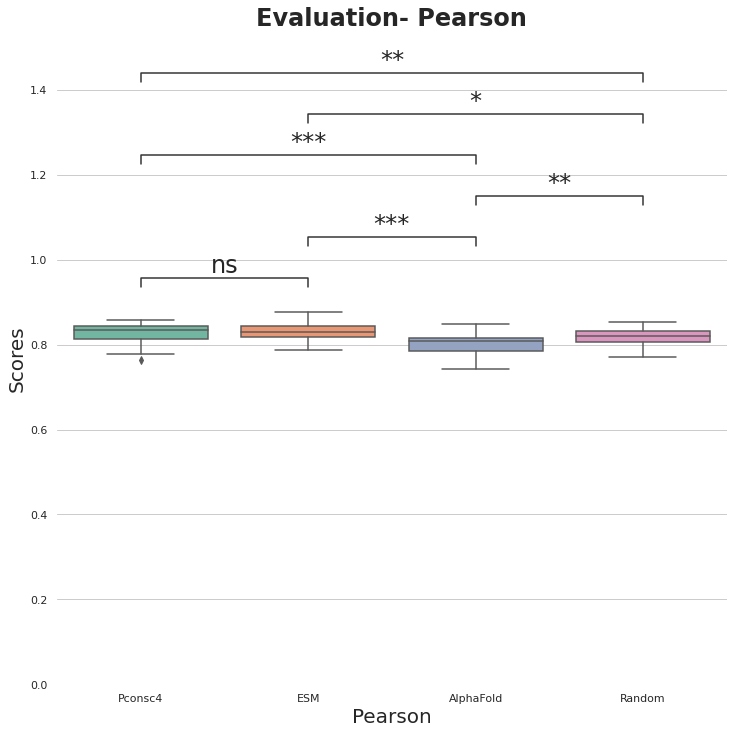

In [44]:
f, ax = plt.subplots(figsize=(12, 12))

# Draw a violinplot with a narrower bandwidth than the default
order = ['Pconsc4', 'ESM', 'AlphaFold', 'Random']
pairs=[("Pconsc4", "ESM"), ("ESM", "AlphaFold"), ("AlphaFold", "Random"),("Pconsc4", "Random"),("Pconsc4", "AlphaFold"),("ESM", "Random")]
sns.set(font_scale = 2)
ax=sns.boxplot(data=data_pearson, palette="Set2",order=order)

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Pearson',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('Evaluation- Pearson',fontsize=24,fontweight='bold')
sns.despine(left=True, bottom=True)
annotator = Annotator(ax, pairs, data=data_pearson, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside')
annotator.apply_and_annotate()
plt.savefig(os.path.join('results2',  'boxplot_pearson1_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results2',  'boxplot_pearson1_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [43]:
pwd

'/rds/user/co-gora1/hpc-work/DGraphDTA'

In [42]:
data_pearson.to_pickle('/rds/user/co-gora1/hpc-work/DGraphDTA/results2/pearson.pkl')

In [ ]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})

In [ ]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})

In [ ]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})

In [56]:
sns.set_theme(style="whitegrid")

### Density Plots

In [35]:
def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')

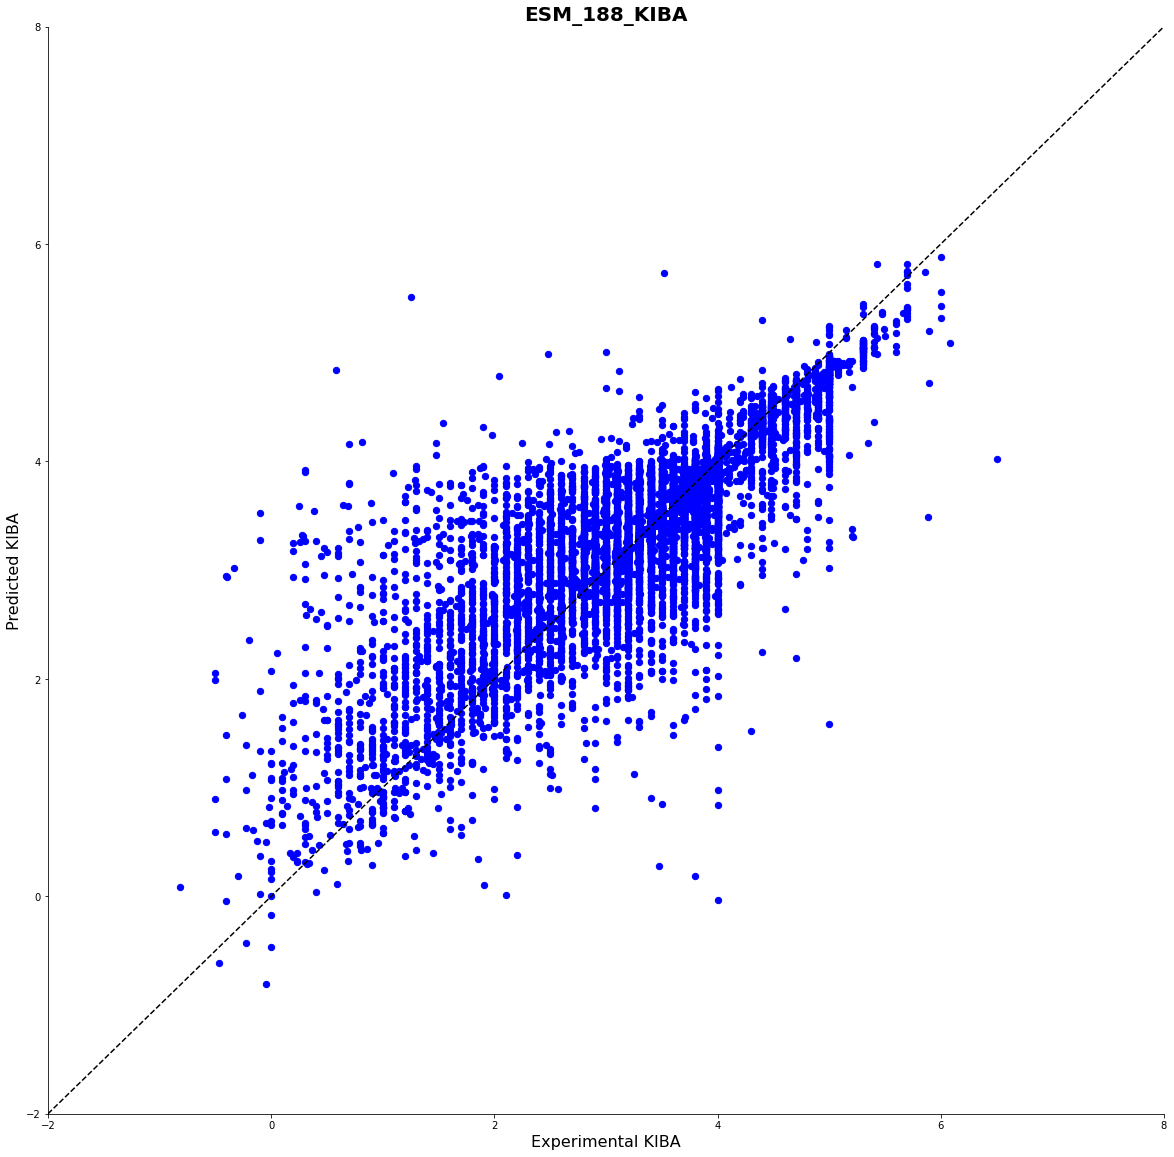

In [19]:
f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.errorbar(x_random, y_random , yerr=y_random -x_random, fmt="o", color="r")
ax.scatter(Y_1,P_1, color='blue', s=40)
plt.plot([-2, 8], [-2, 8], color='black',linestyle="--")
ax.set(ylim=(-2, 8))
ax.set(xlim=(-2,8))
ax.set_ylabel('Predicted KIBA',fontsize=16)
ax.set_xlabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
#ltext = leg.get_texts()
ax.set_title('ESM_188_KIBA',fontsize=20,fontweight='bold')  
plt.show()
# f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

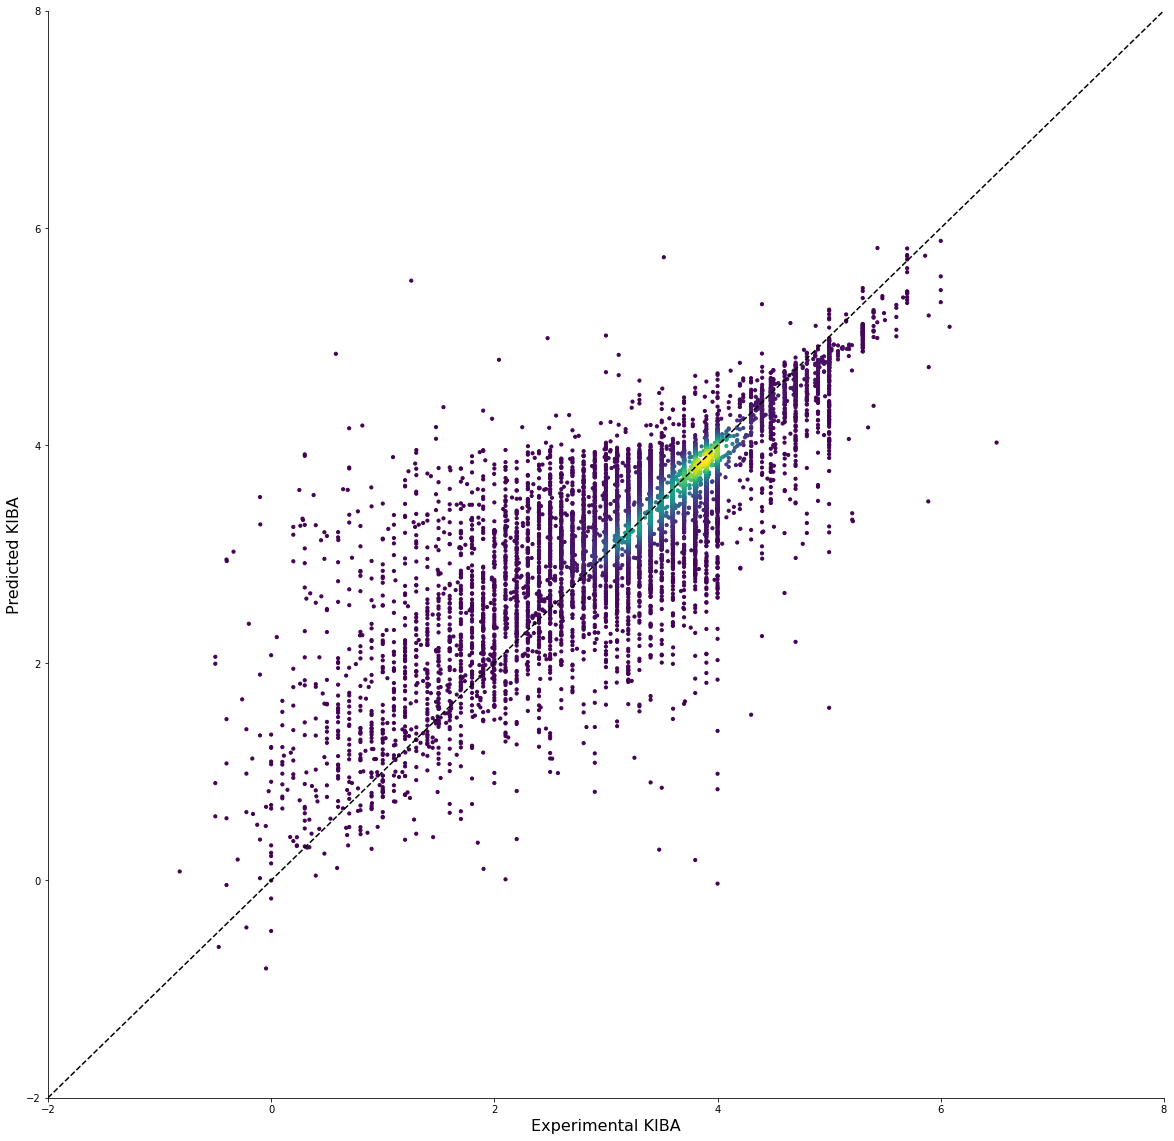

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = Y_1
y = P_1

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.scatter(x, y, c=z, s=10)
plt.plot([-2, 8], [-2, 8], color='black',linestyle="--")
ax.set(ylim=(-2, 8))
ax.set(xlim=(-2,8))
ax.set_ylabel('Predicted KIBA',fontsize=16)
ax.set_xlabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

In [19]:


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


In [20]:
x = Y_1
y = P_1

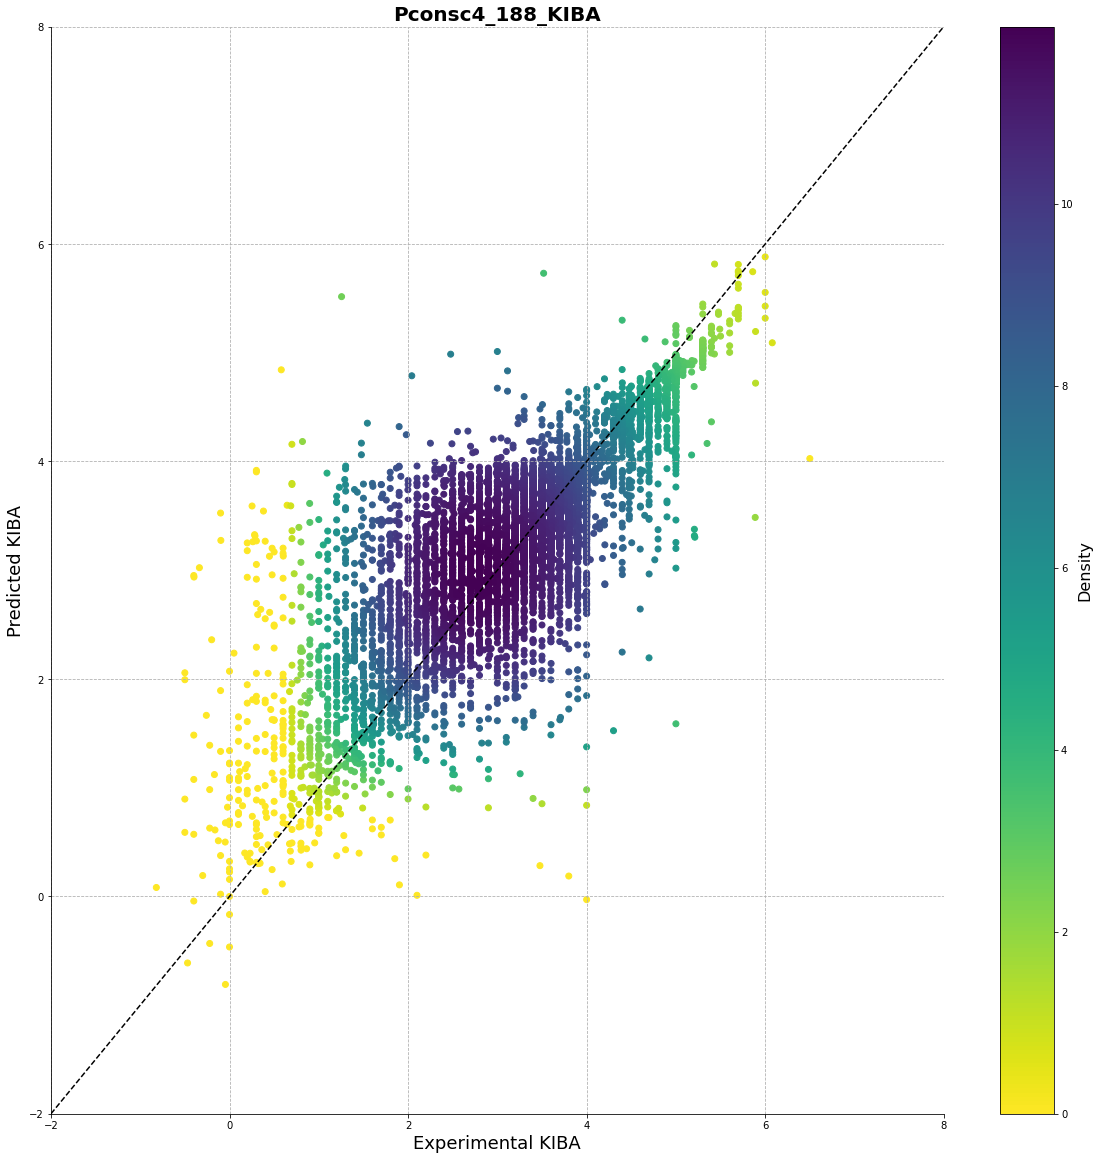

In [21]:
f, ax = plt.subplots(figsize=(20, 20))
plt.grid(linestyle='--')
data , x_e, y_e = np.histogram2d( x, y, bins = [5,5], density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0
# Sort the points by density, so that the densest points are plotted last
sort= True
if sort:
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter( x, y, c=z,cmap='viridis_r')

norm = Normalize(vmin = np.min(z)*100, vmax = np.max(z)*100)
cbar = f.colorbar(cm.ScalarMappable(norm = norm,cmap='viridis_r'), ax=ax)
cbar.ax.set_ylabel('Density',fontsize=16)
#ax.scatter(x, y, c=z, s=10)
plt.plot([-2, 8], [-2, 8], color='black',linestyle="--")
ax.set(ylim=(-2, 8))
ax.set(xlim=(-2,8))
ax.set_ylabel('Predicted KIBA',fontsize=18)
ax.set_xlabel('Experimental KIBA',fontsize=18)
ax.set_title('Pconsc4_188_KIBA',fontsize=20,fontweight='bold') 
leg = plt.gca().get_legend()
plt.show()
# f.savefig(os.path.join('results2',  'densityPlot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# f.savefig(os.path.join('results2',  'densityPlot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')


/tmp/ipykernel_3773291/2487595114.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = f.colorbar(cm.ScalarMappable(norm = norm,cmap='viridis_r'), ax=ax)


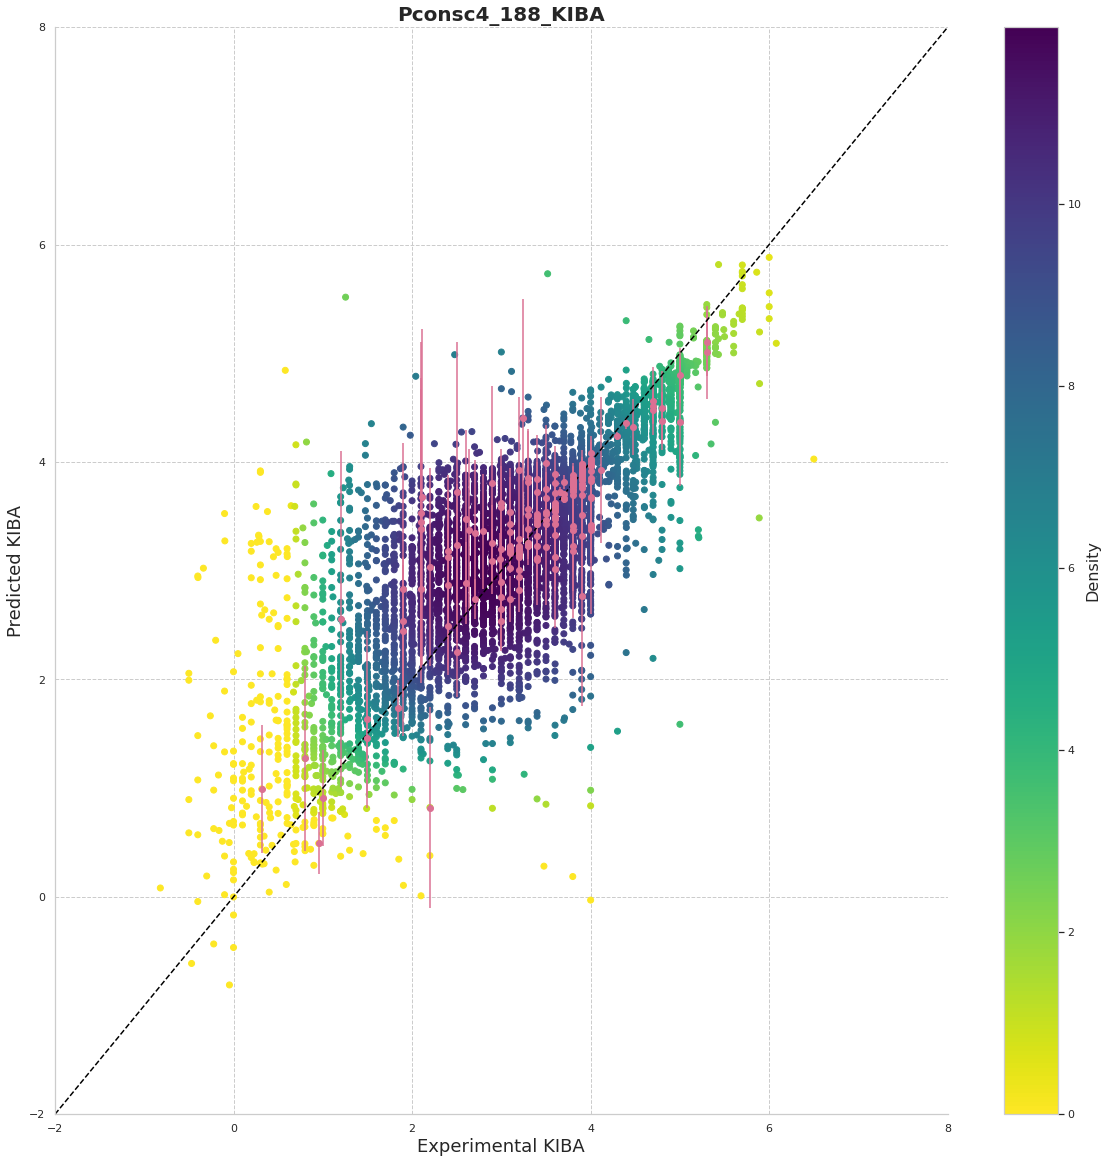

In [88]:
f, ax = plt.subplots(figsize=(20, 20))
plt.grid(linestyle='--')
data , x_e, y_e = np.histogram2d( x, y, bins = [5,5], density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0
# Sort the points by density, so that the densest points are plotted last
sort= True
if sort:
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.scatter( x, y, c=z,cmap='viridis_r')
ax.errorbar( y_random, x_random, yerr=totalers_random, fmt="o", color="palevioletred")

norm = Normalize(vmin = np.min(z)*100, vmax = np.max(z)*100)
cbar = f.colorbar(cm.ScalarMappable(norm = norm,cmap='viridis_r'), ax=ax)
cbar.ax.set_ylabel('Density',fontsize=16)

#ax.scatter(x, y, c=z, s=10)
plt.plot([-2, 8], [-2, 8], color='black',linestyle="--")
ax.set(ylim=(-2, 8))
ax.set(xlim=(-2,8))
ax.set_ylabel('Predicted KIBA',fontsize=18)
ax.set_xlabel('Experimental KIBA',fontsize=18)
ax.set_title('Pconsc4_188_KIBA',fontsize=20,fontweight='bold') 
leg = plt.gca().get_legend()
plt.show()
f.savefig(os.path.join('results2',  'densityPlot_wEbars_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
f.savefig(os.path.join('results2',  'densityPlot_wEbars_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')


In [35]:
data_exps={
    'Experimental_KIBA': Y_1,
    'Predicted_KIBA': P_1
}

In [80]:
sns.set_theme(style="whitegrid")

/home/co-gora1/rds/hpc-work/miniconda3/envs/mldd1/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


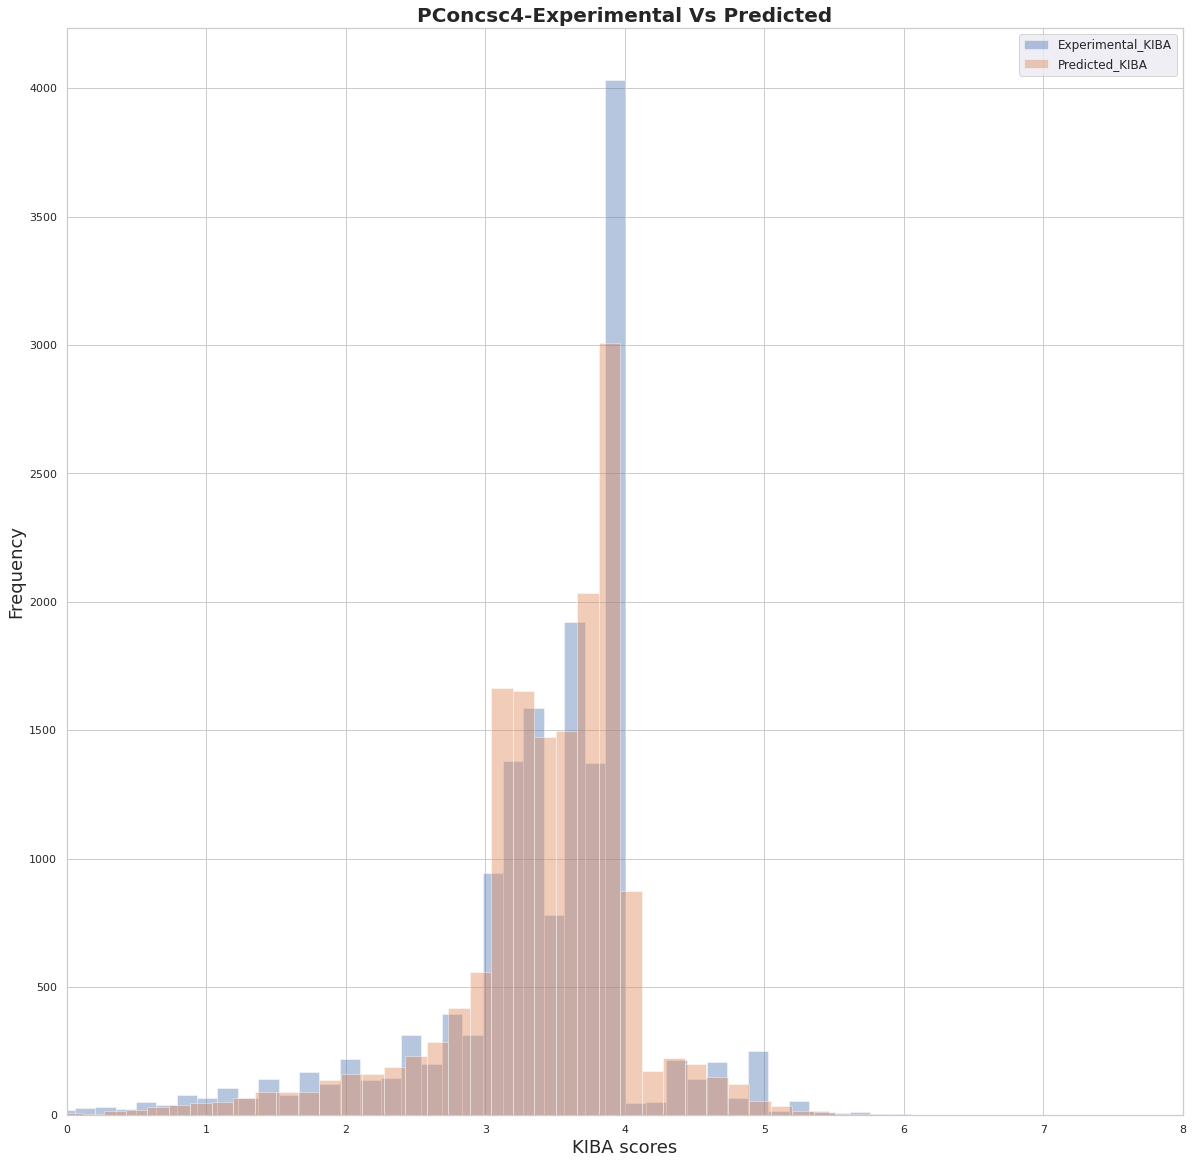

In [67]:
f, ax = plt.subplots(figsize=(20, 20))

sns.set(font_scale = 2)
sns.distplot(data_exps['Experimental_KIBA'],  kde=False,label='Experimental_KIBA',bins=100)
sns.distplot(data_exps['Predicted_KIBA'],  kde=False,label='Predicted_KIBA',bins=100)
ax.legend(prop={'size': 12})
ax.set_title('PConcsc4-Experimental Vs Predicted',fontsize=20,fontweight='bold')
ax.set_xlabel('KIBA scores',fontsize=18)
ax.set(xlim=(0,8))
ax.set_ylabel('Frequency',fontsize=18)
plt.show()
f.savefig(os.path.join('results2',  'hist_pconsc4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
f.savefig(os.path.join('results2',  'hist_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

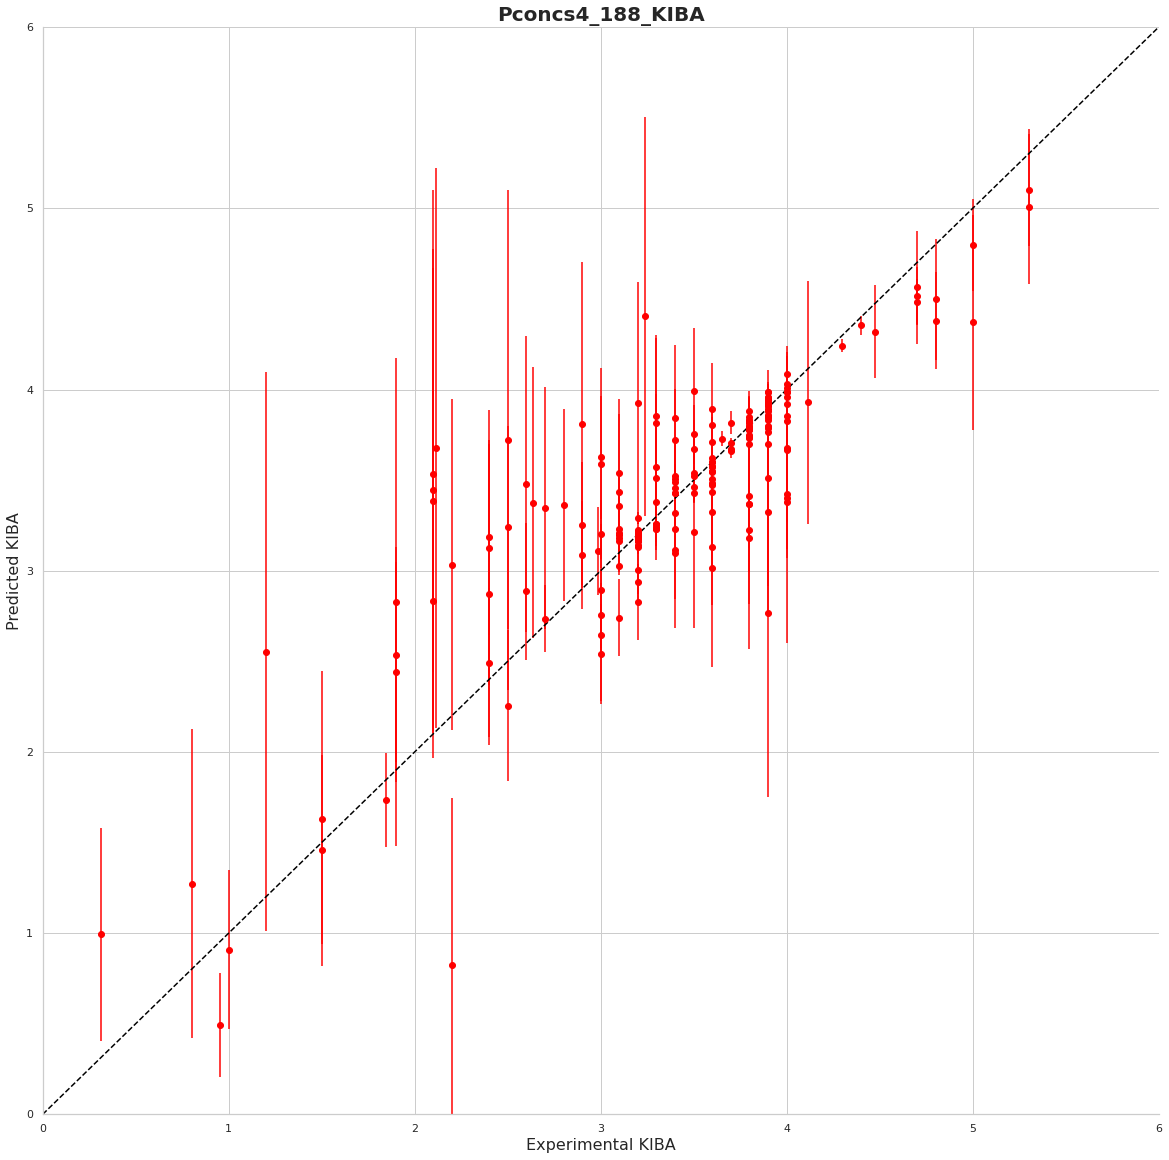

In [86]:
f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar( y_random, x_random, yerr=totalers_random, fmt="o", color="red")
plt.plot([0, 6], [0, 6], color='black',linestyle="--")
ax.set(ylim=(0, 6))
ax.set(xlim=(0,6))
ax.set_ylabel('Predicted KIBA',fontsize=16)
ax.set_xlabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
#ltext = leg.get_texts()
ax.set_title('Pconcs4_188_KIBA',fontsize=20,fontweight='bold')  
plt.show()
f.savefig(os.path.join('results2',  'error_plot_pconcs4_188_2000' + '.png'), dpi=500, bbox_inches='tight')
f.savefig(os.path.join('results2',  'error_plot_pconcs4_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

<AxesSubplot:>

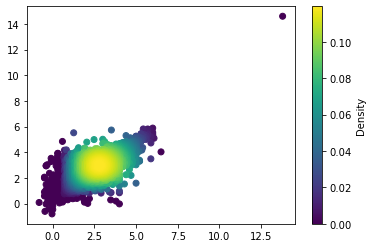

In [48]:
density_scatter( x, y, bins = [5,5] )

### Violin Plot

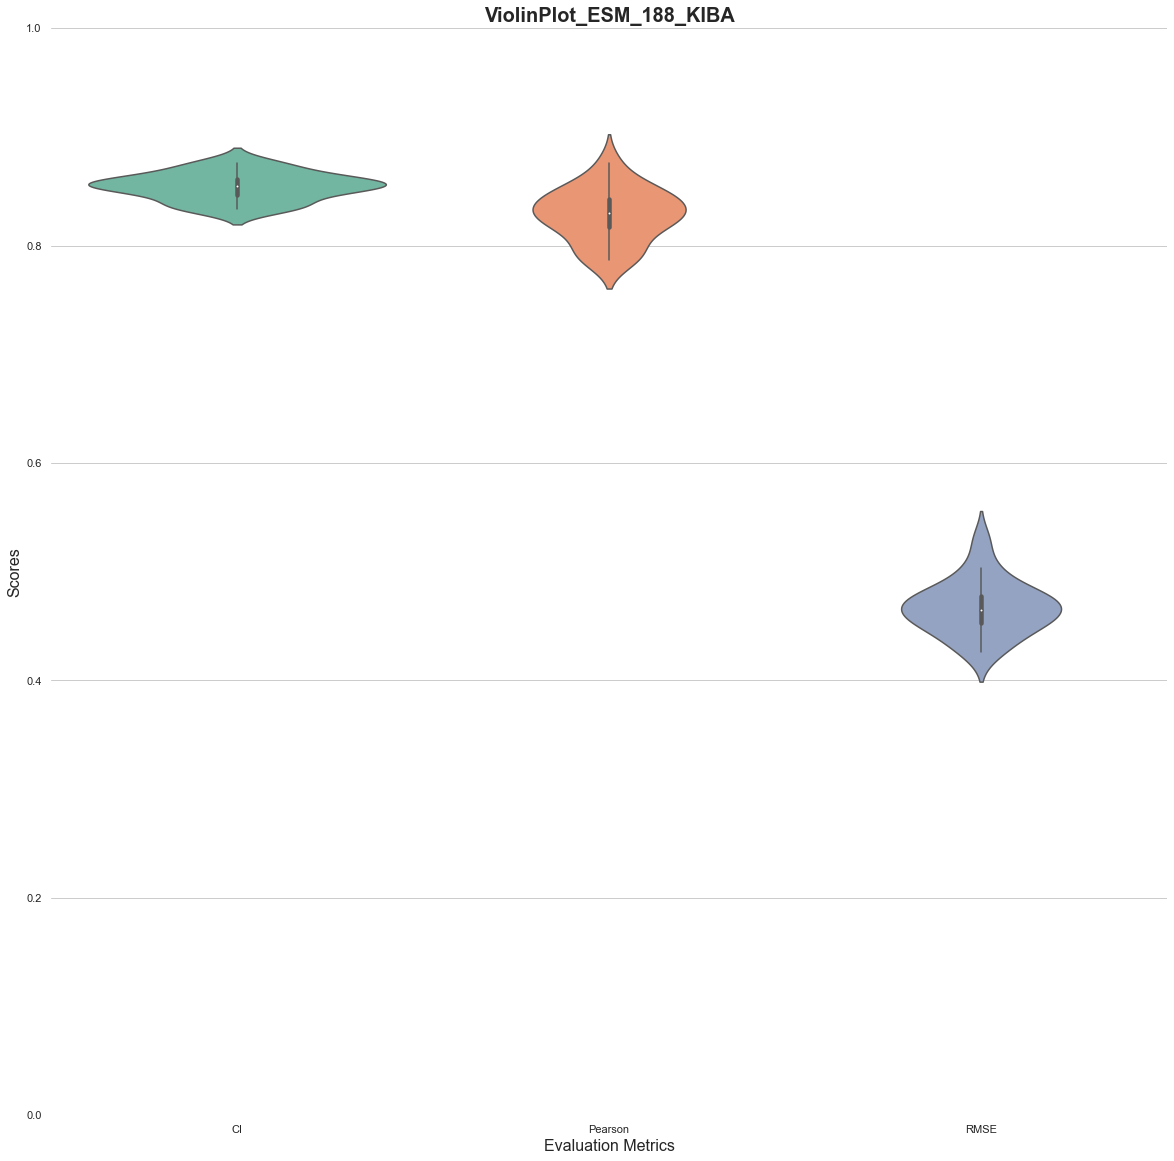

In [14]:
f, ax = plt.subplots(figsize=(20, 20))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0, 1))
ax.set_title
sns.despine(left=True, bottom=True)

ax.set(ylim=(0, 1))
#ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=16)
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('ViolinPlot_ESM_188_KIBA',fontsize=20,fontweight='bold')

plt.savefig(os.path.join('results1',  'violinplot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'violinplot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
### BoxPlot

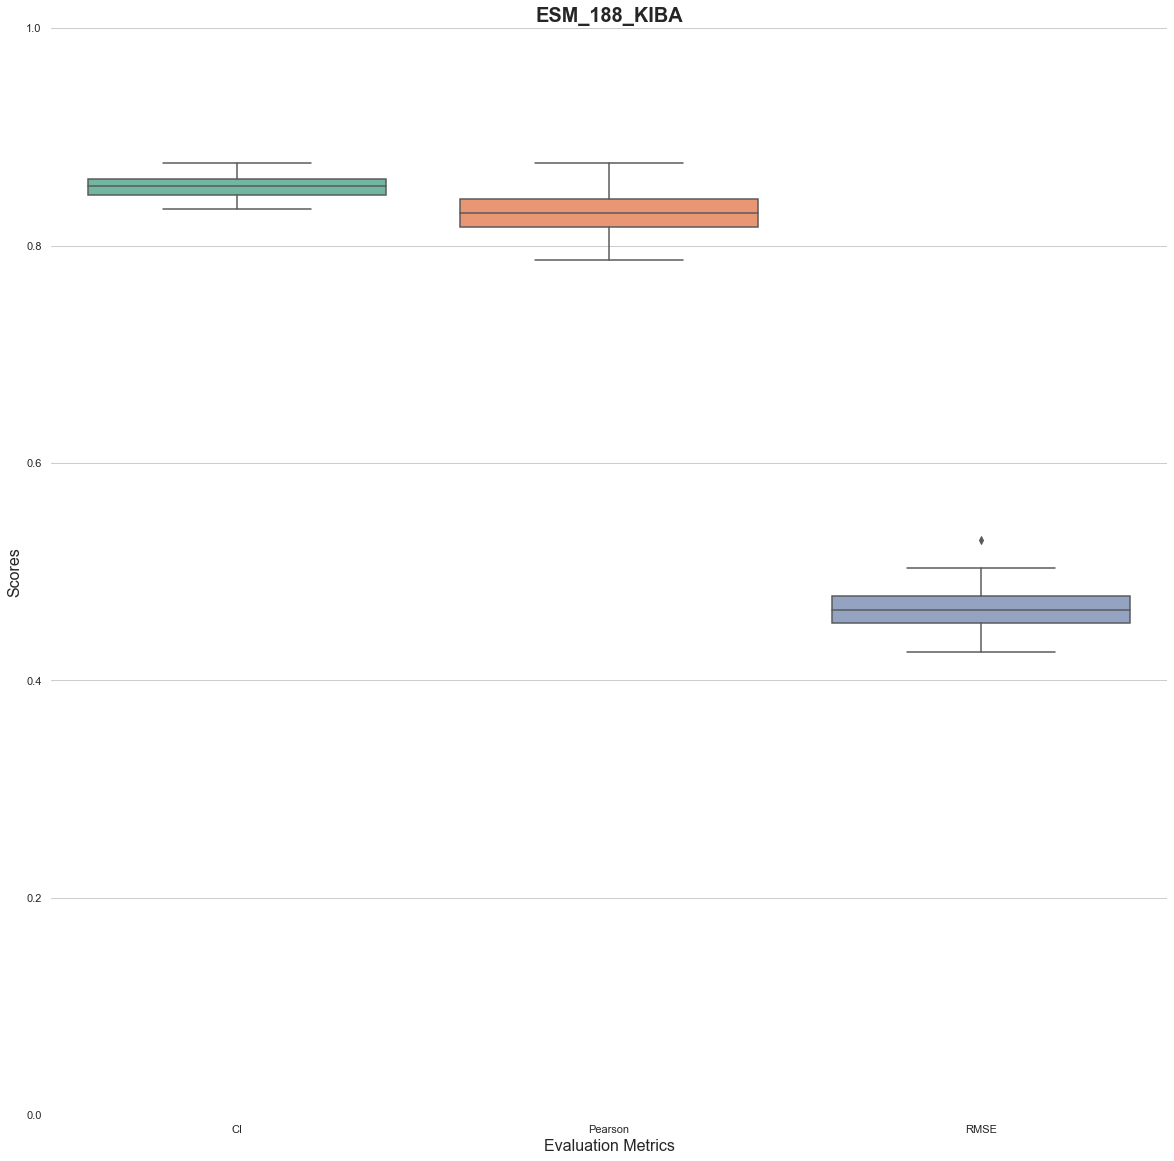

In [15]:
f, ax = plt.subplots(figsize=(20, 20))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=16)
ax.set_ylabel('Scores',fontsize=16)
ax.set_title('ESM_188_KIBA',fontsize=20,fontweight='bold')
sns.despine(left=True, bottom=True)
plt.savefig(os.path.join('results1',  'boxplot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('results1',  'boxplot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
### Violin_Box Matplotlib

/tmp/ipykernel_202180/2850377431.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])


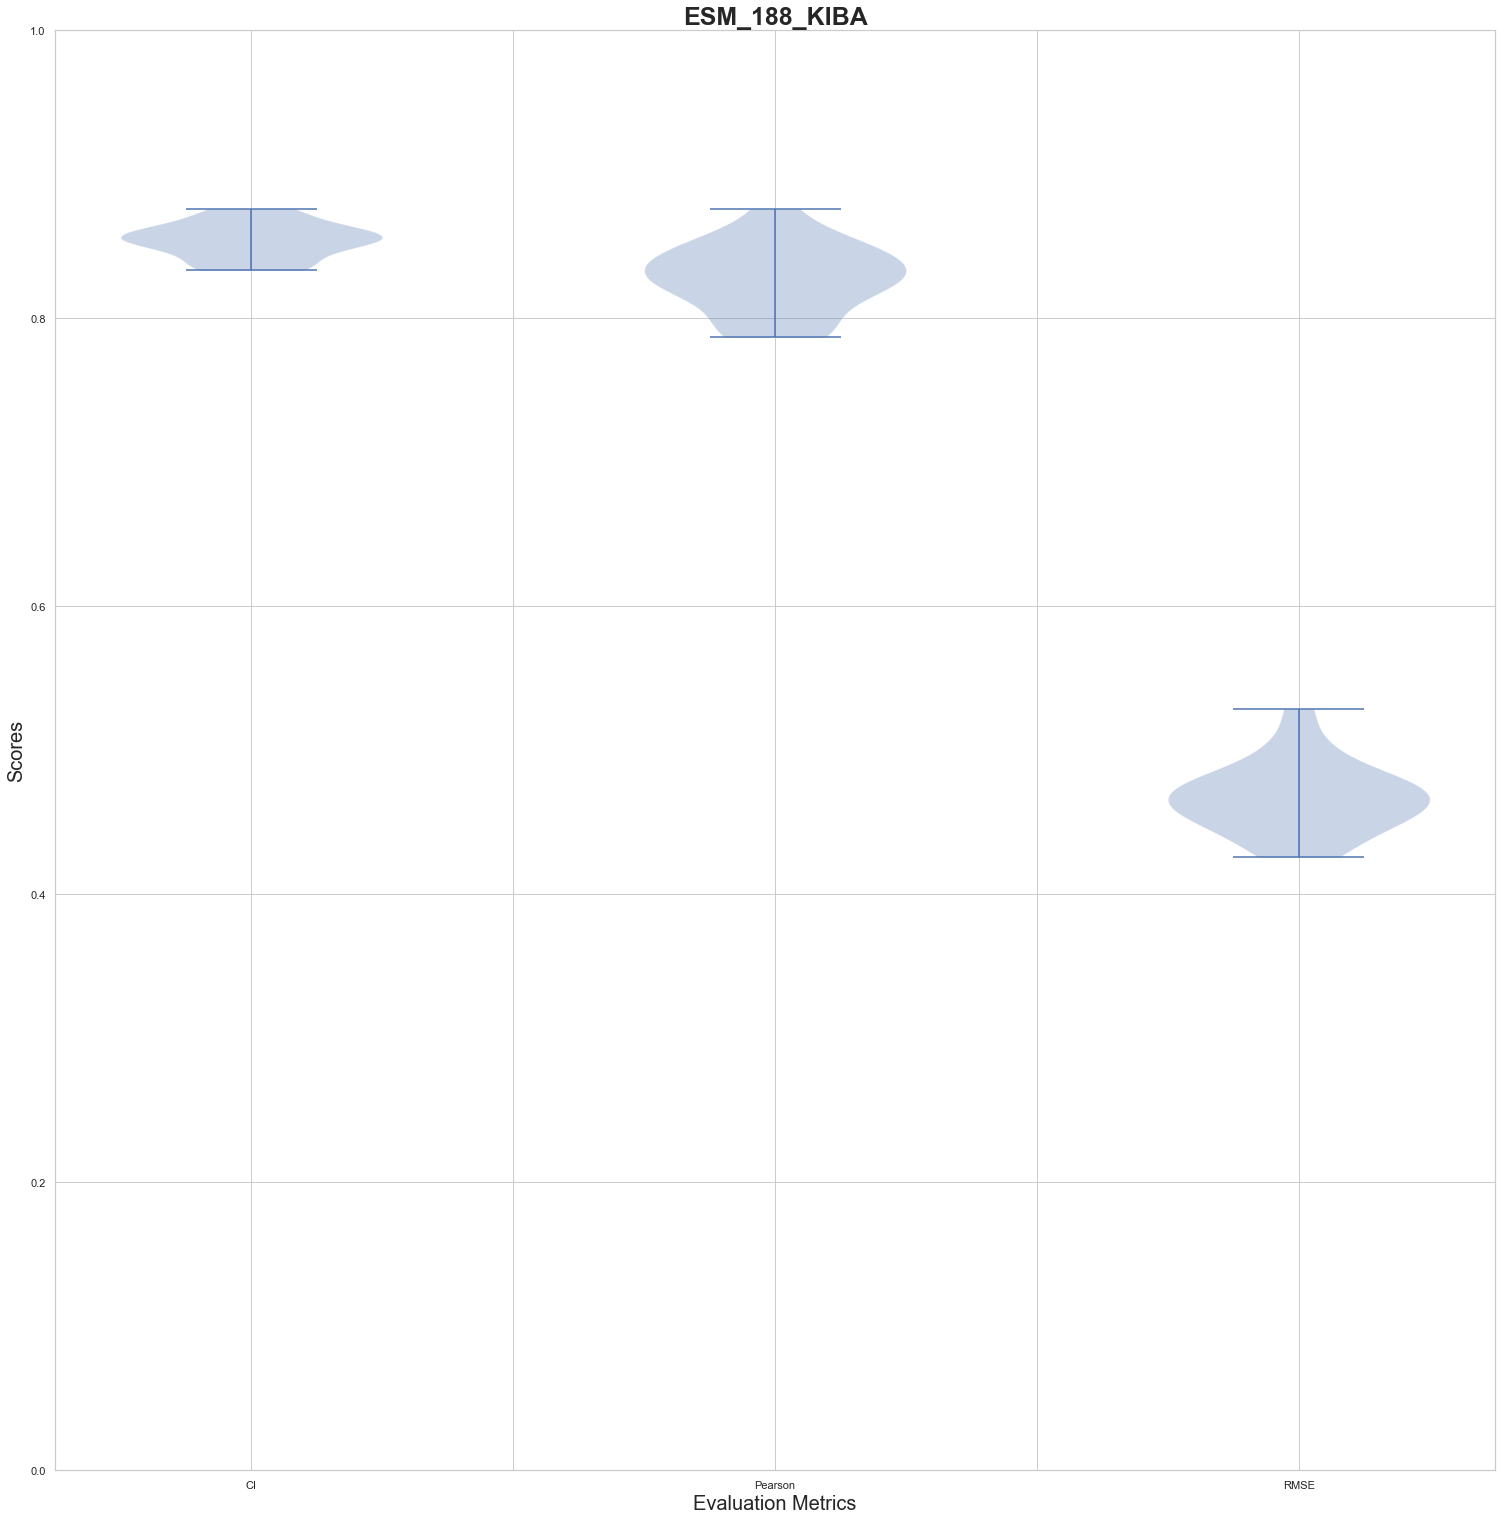

In [16]:

fig = plt.figure(figsize =(20, 20))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])
#ax.set_ylim([0, 1])
ax.set(ylim=(0, 1))
#ax.margins(x=2, y=2)
ax.set_xlabel('Evaluation Metrics',fontsize=20)
ax.set_ylabel('Scores',fontsize=20)
ax.set_title('ESM_188_KIBA',fontsize=25,fontweight='bold')

bp = ax.violinplot(data)
plt.show()
fig.savefig(os.path.join('results1',  'box_violin_plot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results1',  'box_violin_plot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')
# Creating plot



### Error Plots

In [29]:
n = 200  # for 2 random indices
np.random.seed(6)
index = np.random.choice(len(Y), n, replace=False)  
x_random = P[index]
y_random = Y[index]
totalers_random=totalers[index]

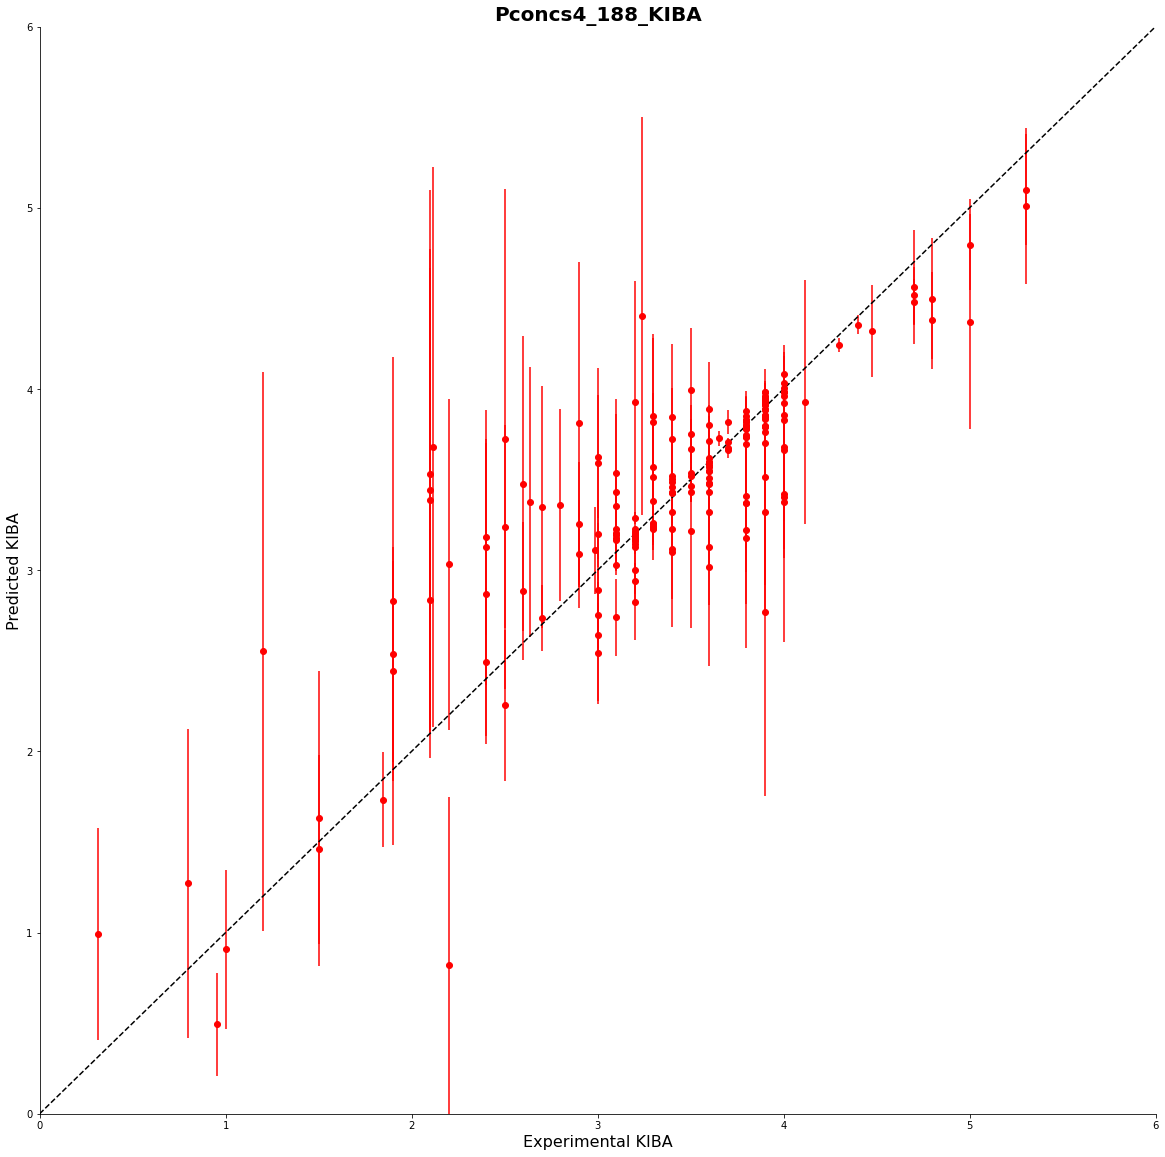

In [30]:
f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar( y_random, x_random, yerr=totalers_random, fmt="o", color="r")
plt.plot([0, 6], [0, 6], color='black',linestyle="--")
ax.set(ylim=(0, 6))
ax.set(xlim=(0,6))
ax.set_ylabel('Predicted KIBA',fontsize=16)
ax.set_xlabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
#ltext = leg.get_texts()
ax.set_title('Pconcs4_188_KIBA',fontsize=20,fontweight='bold')  
plt.show()
# f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [17]:
n = 100  # for 2 random indices
np.random.seed(6)
index = np.random.choice(len(Y), n, replace=False)  
x_random = P[index]
y_random = Y[index]

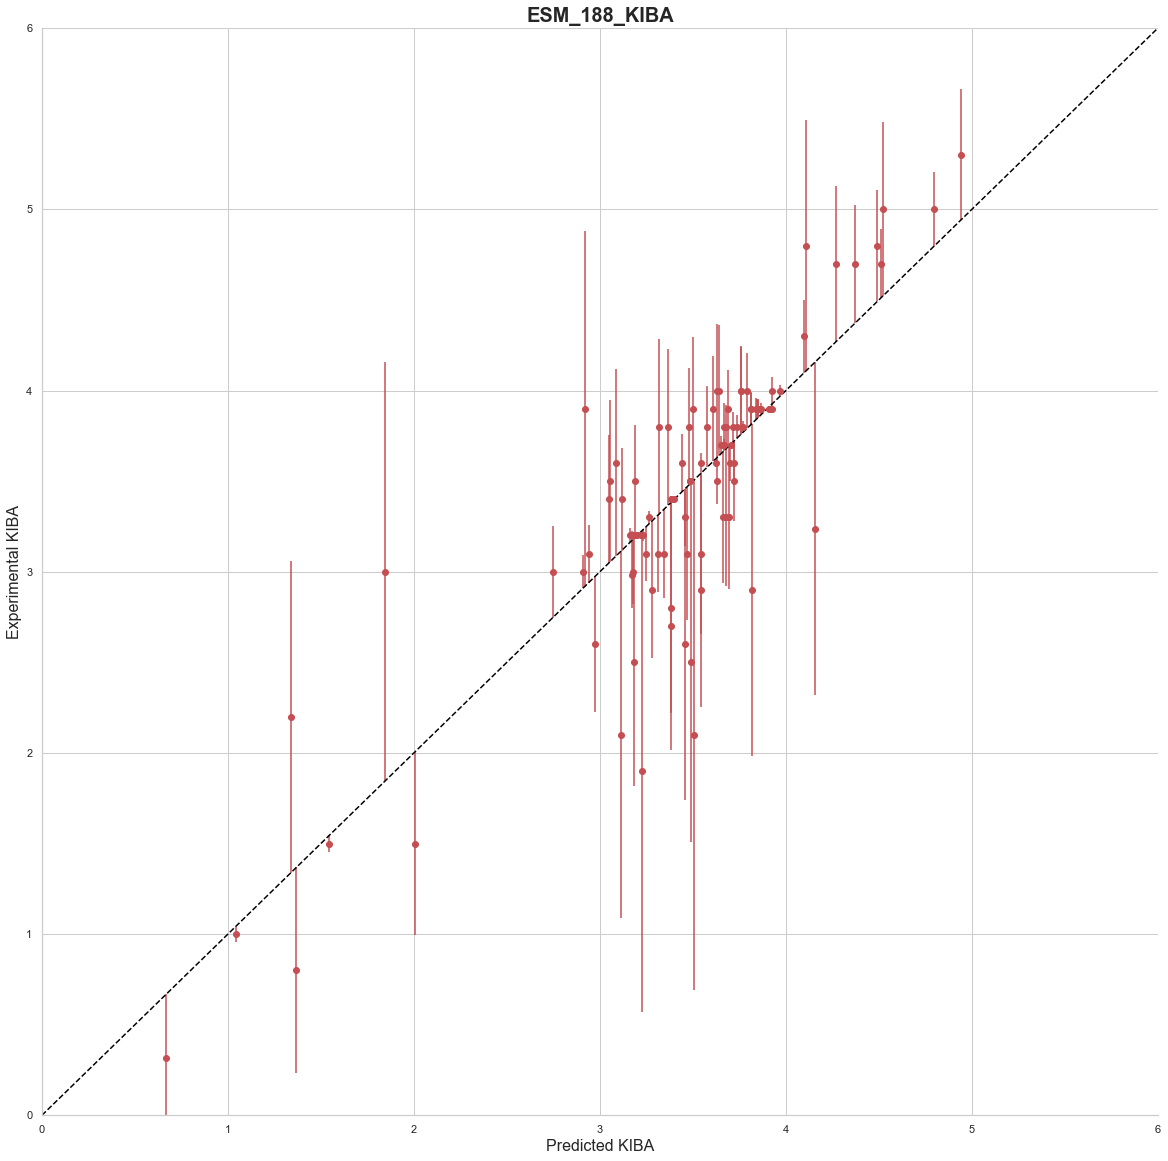

In [18]:
f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar(x_random, y_random , yerr=y_random -x_random, fmt="o", color="r")
plt.plot([0, 6], [0, 6], color='black',linestyle="--")
ax.set(ylim=(0, 6))
ax.set(xlim=(0,6))
ax.set_xlabel('Predicted KIBA',fontsize=16)
ax.set_ylabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
#ltext = leg.get_texts()
ax.set_title('ESM_188_KIBA',fontsize=20,fontweight='bold')  
plt.show()
f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [24]:
n = 100  # for 2 random indices
np.random.seed(6)
index = np.random.choice(len(Y), n, replace=False)  
x_random = P[index]
y_random = Y[index]

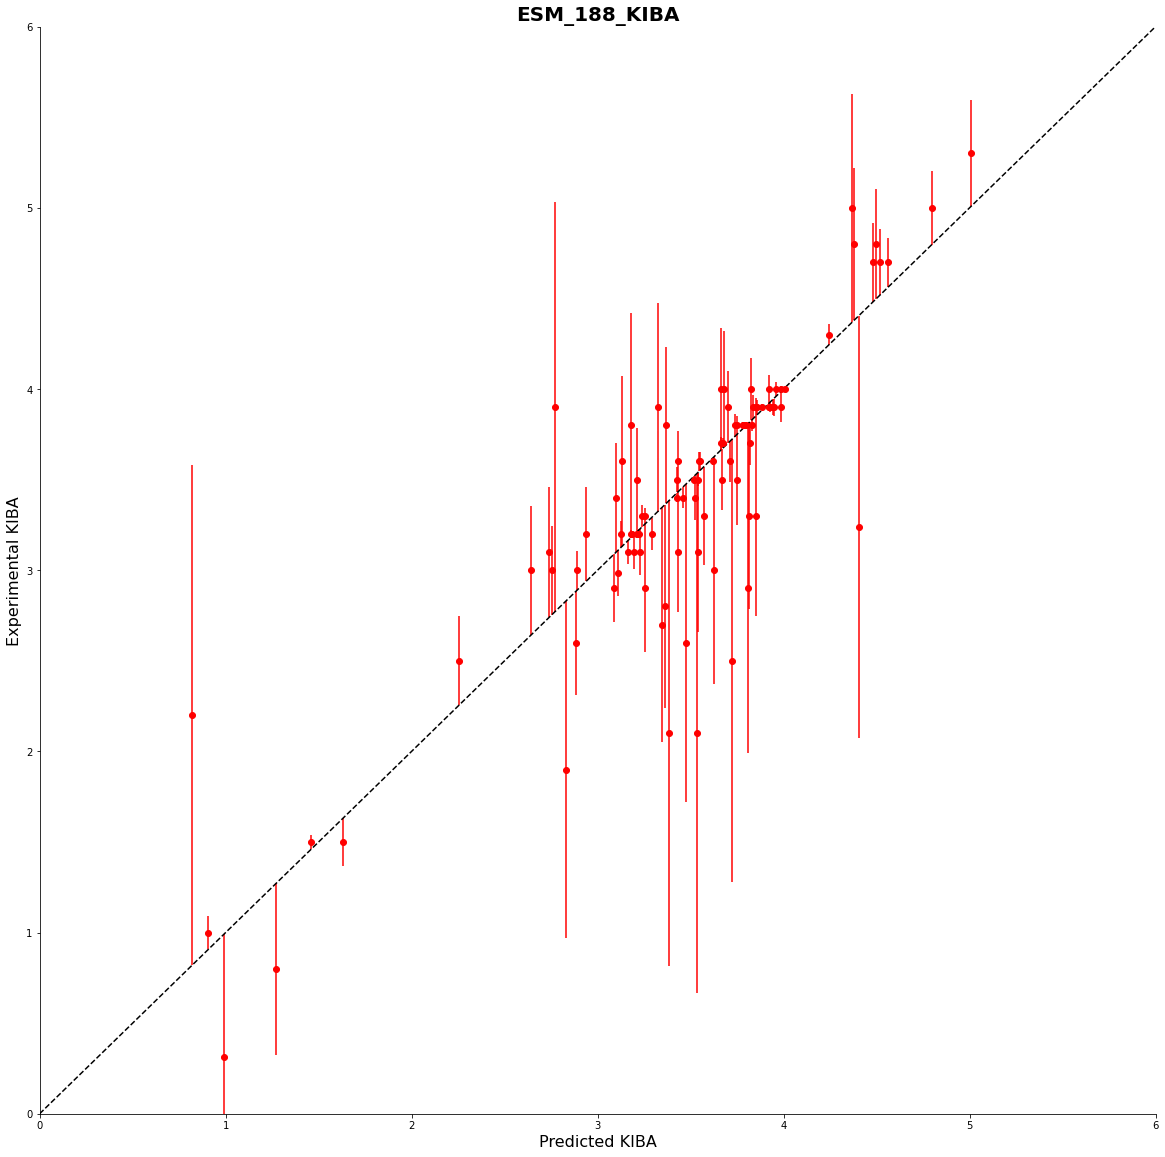

In [25]:
f, ax = plt.subplots(figsize=(20, 20))
#plt.grid(linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.errorbar(y_random,x_random, yerr=y_random -x_random, fmt="o", color="r")
plt.plot([0, 6], [0, 6], color='black',linestyle="--")
ax.set(ylim=(0, 6))
ax.set(xlim=(0,6))
ax.set_xlabel('Predicted KIBA',fontsize=16)
ax.set_ylabel('Experimental KIBA',fontsize=16)
leg = plt.gca().get_legend()
#ltext = leg.get_texts()
ax.set_title('ESM_188_KIBA',fontsize=20,fontweight='bold')  
plt.show()
# f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.png'), dpi=500, bbox_inches='tight')
# f.savefig(os.path.join('results1',  'error_plot_ESM_188_2000' + '.pdf'), dpi=500, bbox_inches='tight')

In [ ]:
def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_pconcs4_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')



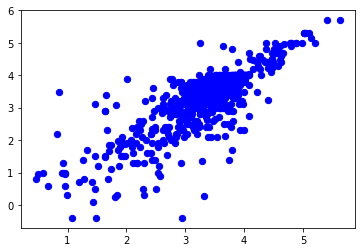

In [26]:
plt.scatter(P, Y, color='blue', s=40)

/home/co-gora1/rds/hpc-work/miniconda3/envs/mldd1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


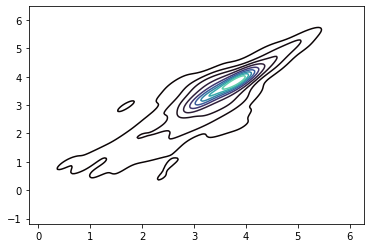

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(P, Y,cmap="mako")
plt.show()

No handles with labels found to put in legend.


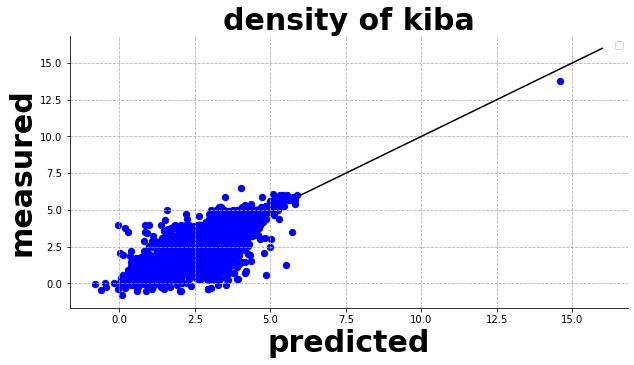

In [9]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


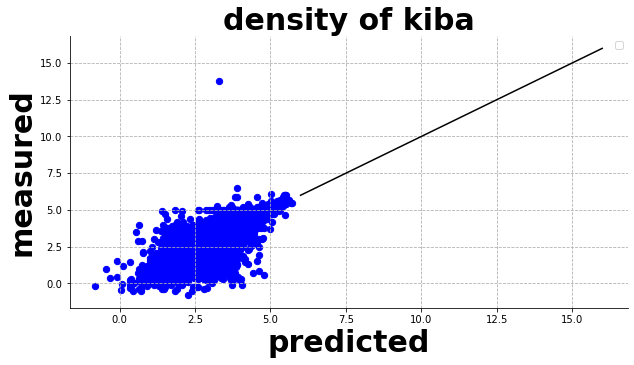

In [15]:
plot_density(Y, P, fold, dataset)

In [18]:
test_loader

In [11]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

In [48]:

my_file = open("alpha500_pred_file.txt", "r")
content = my_file.read()
content=content.splitlines()
content=[float(i) for i in content]
print(content)

[13.572652, 12.826997, 11.444092, 10.318037, 11.341069, 11.559343, 11.85205, 11.203673, 10.334731, 11.582762, 13.900543, 12.97712, 11.691866, 12.792691, 14.458044, 11.520013, 12.257853, 11.212511, 12.006573, 11.880769, 11.1070795, 11.378011, 11.148856, 11.216189, 11.134102, 12.008484, 10.905703, 11.242366, 11.19693, 10.343345, 11.86922, 12.26573, 10.585809, 12.672529, 11.919928, 10.658084, 11.237454, 11.279299, 11.310264, 11.870662, 11.057477, 11.480621, 12.106813, 11.613607, 10.156403, 11.307625, 10.7861595, 11.92269, 11.224873, 12.009879, 10.479592, 11.211487, 11.759775, 11.364248, 11.742957, 12.0676775, 12.2011385, 11.140188, 11.8148365, 11.463266, 11.225105, 11.48033, 12.019633, 11.547219, 11.362604, 12.447442, 10.850902, 11.337198, 10.871161, 11.64067, 11.490308, 11.450138, 11.544379, 10.872649, 12.062119, 11.466935, 11.917785, 11.780647, 11.215674, 12.046588, 11.4404955, 10.219847, 11.889244, 11.15485, 11.559784, 12.427896, 12.339859, 10.860705, 12.2455225, 11.580148, 11.404127, 

In [49]:
P1=np.asarray(content)

In [50]:
P1

array([13.572652 , 12.826997 , 11.444092 , ..., 11.422882 , 11.5344305,
       11.544348 ])

In [52]:
plt.scatter(P,color='blue')

TypeError: scatter() missing 1 required positional argument: 'y'

In [37]:
type(content)

str

In [41]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

In [21]:
plot_density(P, Y, 3, dataset)

NameError: name 'dataset' is not defined

In [12]:
with open('pconsc4_500_gt_file.txt', 'w') as f:
    for item in list(Y):
        f.write("%s\n" % item)

In [13]:
with open('pconsc4_500_pred_file.txt', 'w') as f:
    for item in list(P):
        f.write("%s\n" % item)

No handles with labels found to put in legend.


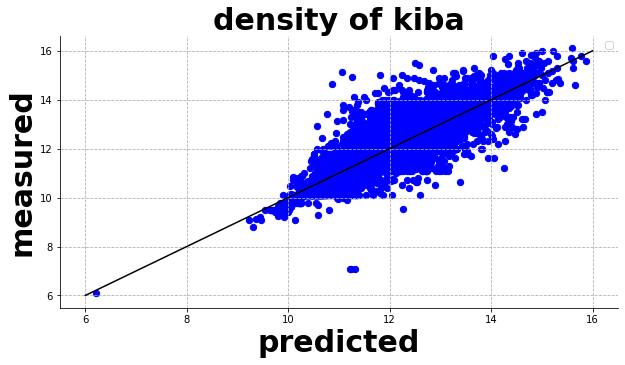

In [54]:
plot_density(Y, P, fold, dataset)

In [58]:
def plot_density1(Y, P,P1, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.scatter(P1, Y, color='green', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + 'alpha v/s pconsc4_500_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No handles with labels found to put in legend.


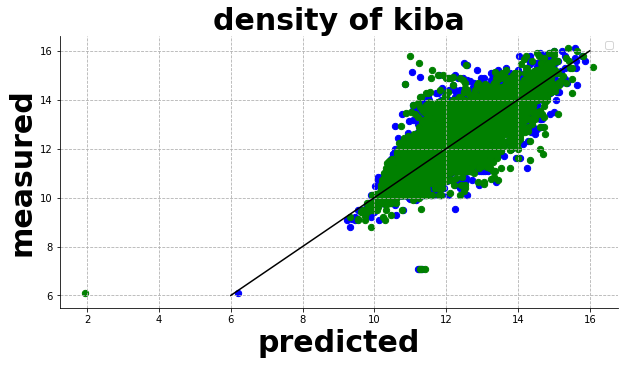

In [59]:
plot_density1(Y, P,P1, fold, dataset)

No handles with labels found to put in legend.


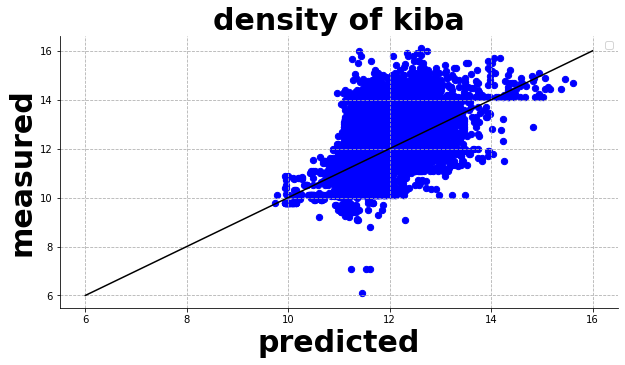

In [13]:
plot_density(Y, P, fold, dataset)

In [ ]:
plot_density(Y, P, fold, dataset)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'

In [8]:

def calculate_metrics1(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
    return cindex,pearson,rmse,Y,P
#     result_file_name = 'results/result_pconcs4_188_2000_' + model_st + '_' + dataset + '.txt'
#     result_str = ''
#     result_str += dataset + '\r\n'
#     result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
#         pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
#     print(result_str)
#     open(result_file_name, 'w').writelines(result_str)

In [9]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_pconsc4__188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/resul_pconsc4__188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))


GNNNet Loaded


<All keys matched successfully>

0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8616694988146936
cindex2 0.8587943619216536
rm2: 0.6752159361477695
mse: 0.20807728
pearson 0.8235589360175168
0.8616694988146936 0.8235589360175168 0.4561548878544279
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8511974431511434
cindex2 0.8481224954870757
rm2: 0.577744193184537
mse: 0.22741851
pearson 0.7782227931510187
0.8511974431511434 0.7782227931510187 0.47688417053404253
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8559298108454405
cindex2 0.8586343755756322
rm2: 0.6281498485614005
mse: 0.23502246
pearson 0.8055174588394287
0.8559298108454405 0.8055174588394287 0.48479114622058916
3
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective 

In [11]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
data11 = pd.DataFrame(
{'CI':data_1,
 'Pearson': data_2,
 'RMSE': data_3
})


In [21]:
import seaborn as sns
sns.set_theme(style="whitegrid")

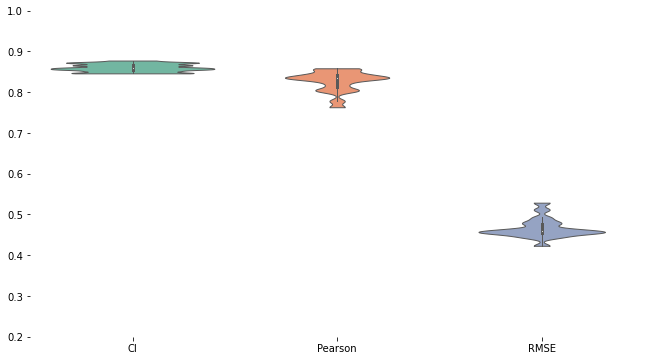

In [13]:
f, ax = plt.subplots(figsize=(11, 6))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2", bw=.2, cut=0, linewidth=1)

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

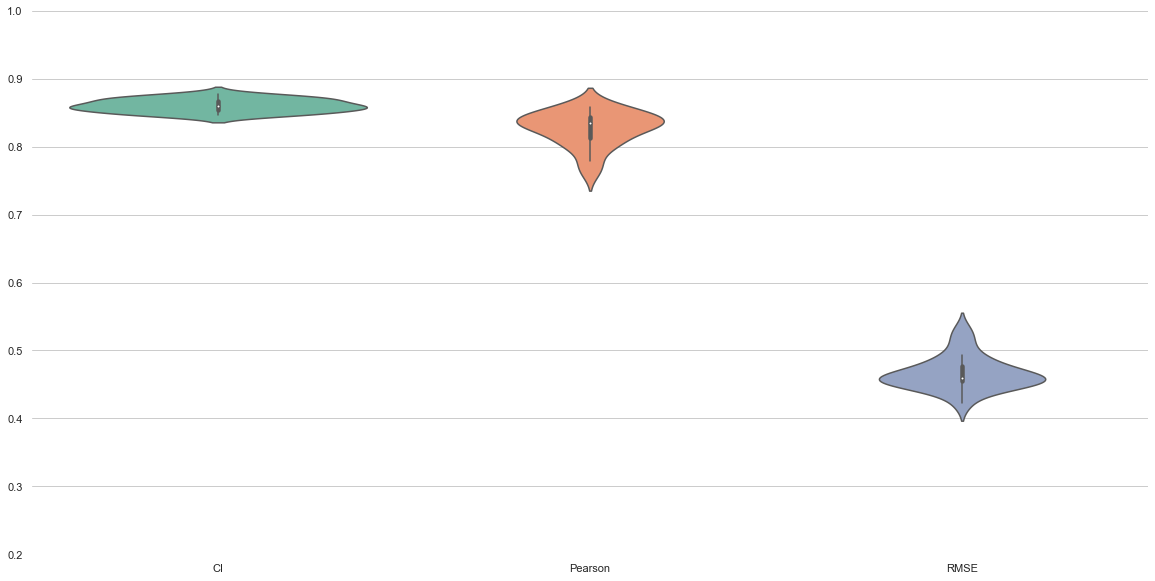

In [22]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

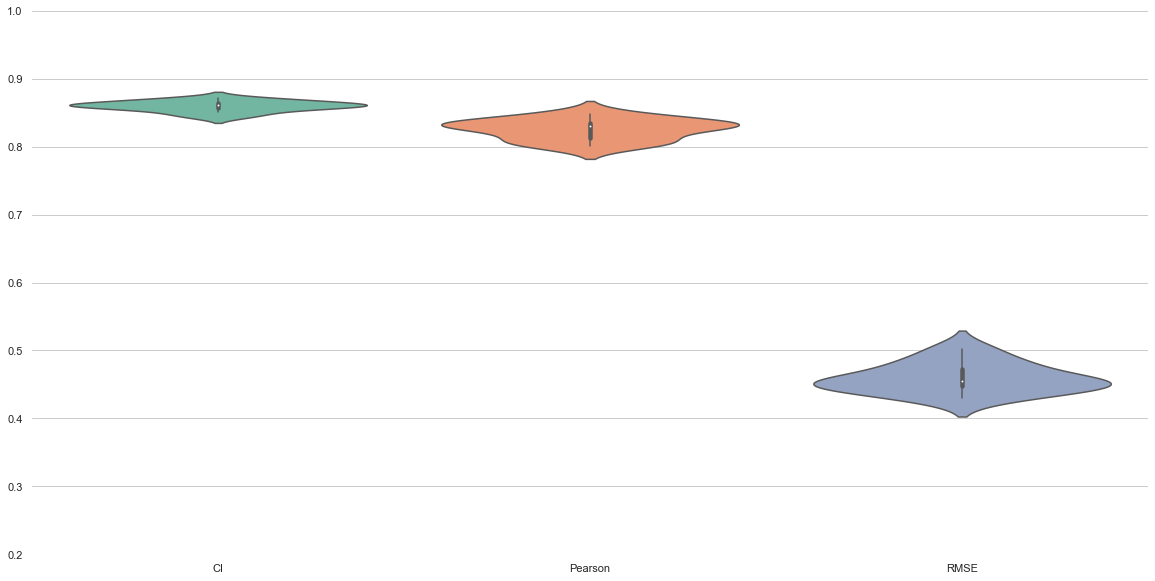

In [62]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=data11, palette="Set2",split=True,scale="width",inner="box")

# Finalize the figure
ax.set(ylim=(0.2, 1))
sns.despine(left=True, bottom=True)

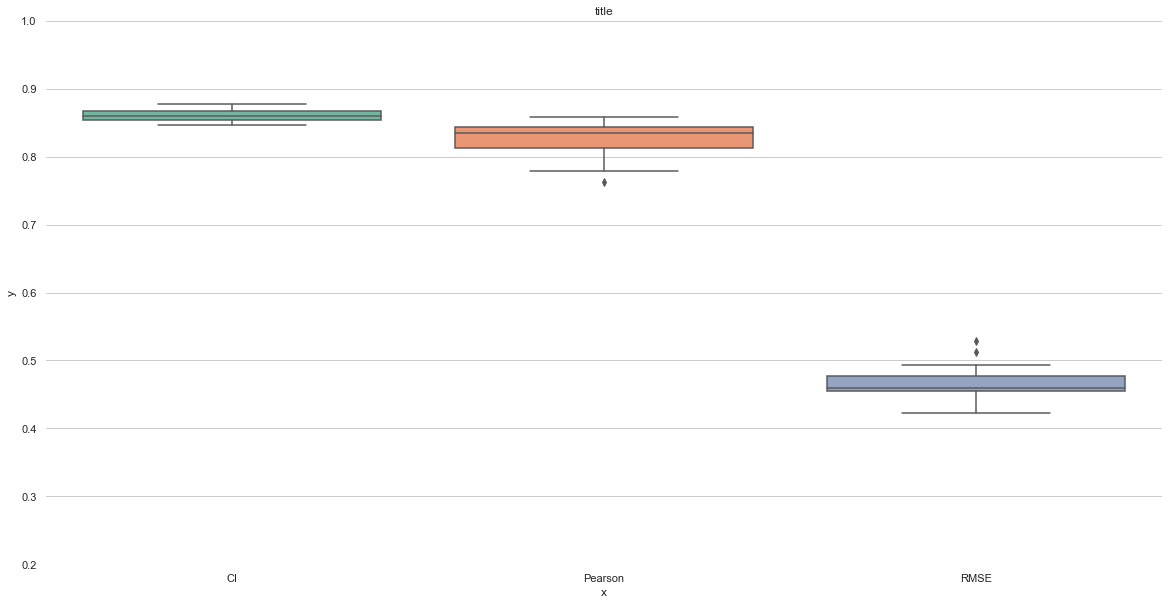

In [23]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0.2, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title')
sns.despine(left=True, bottom=True)

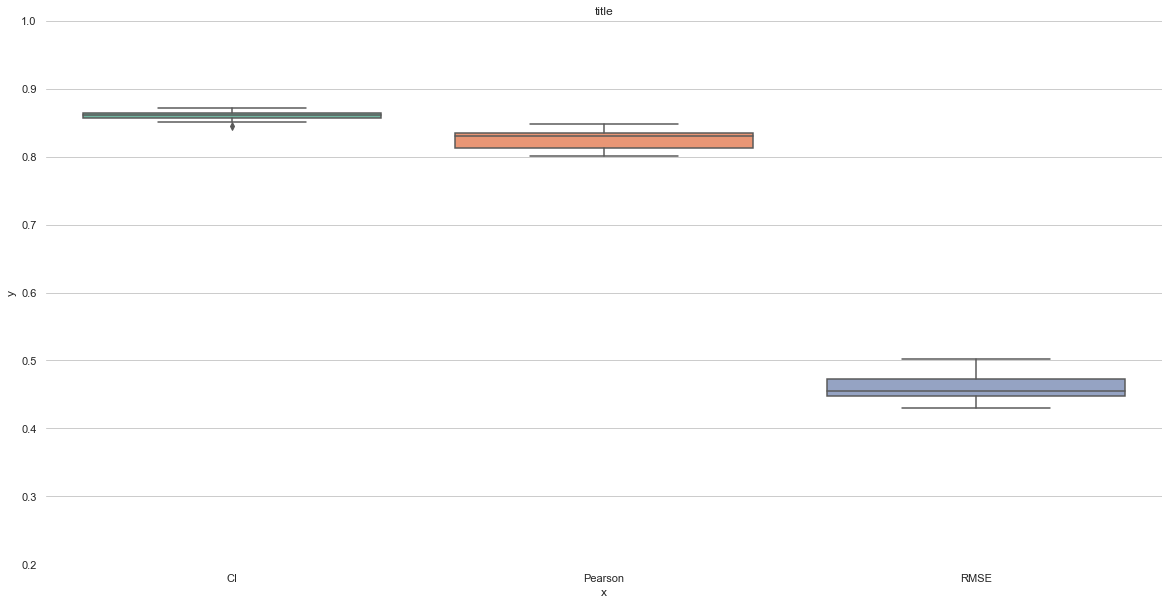

In [43]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.set_theme(style="whitegrid")
# Draw a violinplot with a narrower bandwidth than the default
sns.boxplot(data=data11, palette="Set2")

# Finalize the figure
ax.set(ylim=(0.2, 1))
ax.margins(x=2, y=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title')
sns.despine(left=True, bottom=True)
#sns.despine(offset=10, trim=True)

/tmp/ipykernel_179503/2520841170.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])


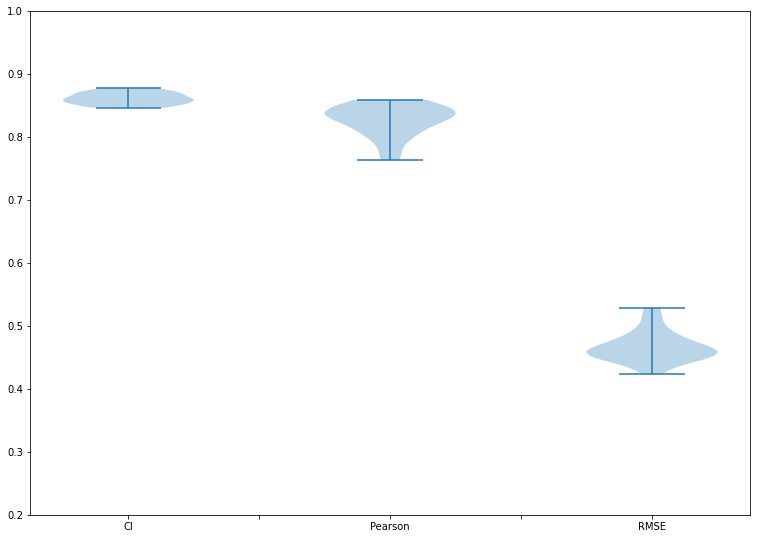

In [16]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
ax.set_xticklabels(["",'CI', "",'Pearson',"", 'RMSE'])
ax.set_ylim([0.2, 1])
# Creating plot
bp = ax.violinplot(data)
plt.show()

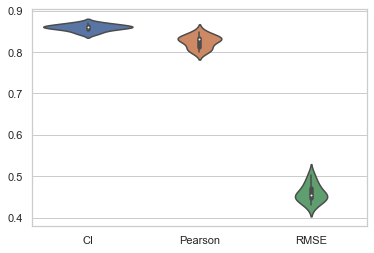

In [65]:
#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots()
# Creating axes instance
#ax = fig.add_axes([0, 0, 1,1])
#ax = fig.add_subplot(111)
#ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
#ax.set_ylim([0.2, 1])
# Creating plot
.violinplot(data=data11,ax=ax)
plt.show()

/tmp/ipykernel_172230/1480089813.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])


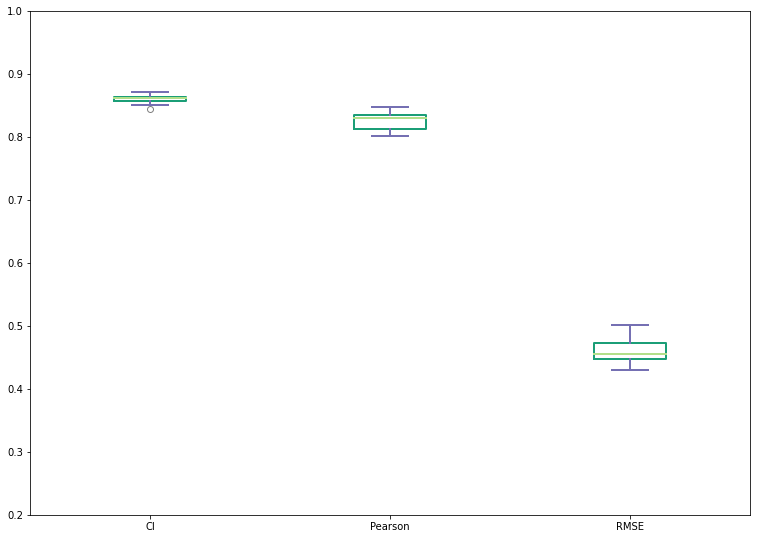

In [17]:
data_1 = ci1
data_2 = pearson1
data_3 = rmse1

data = [data_1, data_2, data_3]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
ax.set_ylim([0.2, 1])
# Creating plot
bp = ax.boxplot(data)
# bp = ax.boxplot(data, patch_artist=True)
# ax.set_xticklabels(['CI', 'Pearson', 'RMSE'])
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set(color = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
# show plot
plt.show()

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (3).

In [8]:
test_data = create_dataset_for_test_bootstrap(dataset, method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/disk/scratch/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


In [9]:
test_data

DTADataset(2000)

In [9]:
test_loader

In [ ]:
Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    

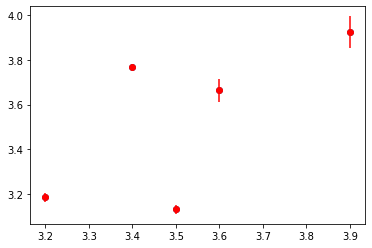

In [20]:
a = [3.199999,3.6,3.4000006,3.8999999,3.50]
b = [3.1865768,3.6635284,3.766081,3.9235876,3.1323996]
plt.scatter(a, b)
d = [0.02, 0.05, 0.01, 0.07,0.02]
  
# you can use color ="r" for red or skip to default as blue
plt.errorbar(a, b, yerr=d, fmt="o", color="r")
  
plt.show()

In [24]:
test_data = create_dataset_for_test_bootstrap(dataset, method,random=30)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
Y, P = predicting(model, device, test_loader)

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...


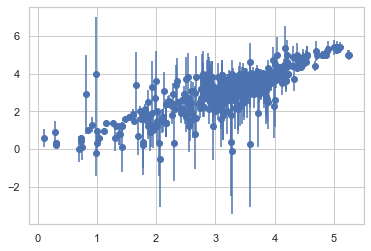

In [30]:
plt.errorbar(P, Y, yerr=Y-P, fmt="o", color="b")
  
plt.show()

In [31]:
type(Y)

numpy.ndarray

In [39]:
n = 200  # for 2 random indices
index = np.random.choice(len(Y), n, replace=False)  

In [40]:
x_random = P[index]
y_random = Y[index]

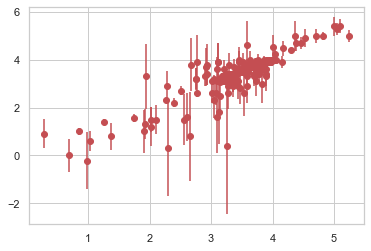

In [41]:
plt.errorbar(x_random, y_random , yerr=y_random -x_random, fmt="o", color="r")
  
plt.show()

In [87]:

niters=100

for i in range(niters):
    print(i)
    test_data = create_dataset_for_test_bootstrap(datasets, method,random=i)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y100, P100 = predicting(model2, device, test_loader)
    cindex,pearson,rmse,mse,rm2=calculate_metrics1(Y3, P3, datasets)
    print(cindex,pearson,rmse)
    



0
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
1
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
2
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.4

effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
25
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
26
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
27
dataset: kiba
test entries: 15932 effective

Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
49
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
50
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
51
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effec

metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
73
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
74
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
75
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction 

dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
98
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.46108456867814823
99
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187
Make prediction for 1000 samples...
metrics for  kiba
cindex: 0.8614526786057497
cindex2 0.8463847576103062
rm2: 0.6392575537557809
mse: 0.21259898
pearson 0.8337876772993008
0.8614526786057497 0.8337876772993008 0.4